In [1]:
import torch

seed = 17
device = "mps"

# Data
N = 100
P = 600
P_eval = 300
C = 10
binarize = True

# Model
H = 300
num_layers = 2
max_steps = 5
init_mode = "zeros"
init_noise = 0.0
fc_left = False
fc_right = False
fc_input = False
symmetric_W = False
double_dynamics = False
double_update = False
use_local_ce = False
beta_ce = 10.0
lambda_cylinder = None

# Couplings
lambda_x = 0.0
lambda_y = 1000.0
lambda_l = 1.0
lambda_r = 1.0
lambda_wback = 0.33
lambda_wforth = 1.0
lambda_internal = 1.0
lambda_fc = 1.0
J_D = 0.5

lambda_input_skip = [1.0, 0.0]
lambda_input_output_skip = 0.0  # multiplied by L
lambda_wback_skip = [0.0]
lambda_wforth_skip = [0.0]
lr_input_output_skip = 0.1
lr_input_skip = 0.03
lr_wforth_skip = 0.1
weight_decay_wforth_skip = 0.005
weight_decay_input_skip = 0.0
weight_decay_input_output_skip = 0.005

# Training
num_epochs = 100
batch_size = 16
# lr_J = 0.05
# lr_W = 0.1
# threshold_hidden = 2.5
# threshold_readout = 5.0
# weight_decay_J = 0.1
# weight_decay_W = 0.02

# Evaluation
eval_interval = 1
skip_representations = True
skip_couplings = False

In [2]:
# Assemble the pieces
# lr = [lr_J] * num_layers + [lr_W] * 2
# weight_decay = [weight_decay_J] * num_layers + [weight_decay_W] * 2
# threshold = [threshold_hidden] * num_layers + [threshold_readout]
lambda_left = [lambda_x] + [lambda_l] * (num_layers - 1) + [lambda_wforth]
lambda_right = [lambda_r] * (num_layers - 1) + [lambda_wback] + [lambda_y]

lr = [
    0.03,
    0.03,
    0.0,
    0.1,
]
threshold = [
    0.75,
    1.25,
    3.0,
]
weight_decay = [
    0.005,
    0.005,
    0.0,
    0.005,
]

In [3]:
from src.data import prepare_mnist

train_inputs, train_targets, eval_inputs, eval_targets, projection_matrix = (
    prepare_mnist(
        P * C,
        P_eval * C,
        N,
        binarize,
        seed,
        shuffle=True,
    )
)
train_inputs = train_inputs.to(device)
train_targets = train_targets.to(device)
eval_inputs = eval_inputs.to(device)
eval_targets = eval_targets.to(device)

In [4]:
import os

from src.batch_me_if_u_can import BatchMeIfUCan
from src.handler import Handler

output_dir = "prova"
os.makedirs(output_dir, exist_ok=True)

model_kwargs = {
    "num_layers": num_layers,
    "N": N,
    "C": C,
    "lambda_left": lambda_left,
    "lambda_right": lambda_right,
    "lambda_internal": lambda_internal,
    "J_D": J_D,
    "device": device,
    "seed": seed,
    "lr": torch.tensor(lr),
    "threshold": torch.tensor(threshold),
    "weight_decay": torch.tensor(weight_decay),
    "init_mode": init_mode,
    "init_noise": init_noise,
    "symmetric_W": symmetric_W,
    "double_dynamics": double_dynamics,
    "double_update": double_update,
    "use_local_ce": use_local_ce,
    "beta_ce": beta_ce,
    "fc_left": fc_left,
    "fc_right": fc_right,
    "fc_input": fc_input,
    "lambda_fc": lambda_fc,
    "lambda_wback_skip": lambda_wback_skip,
    "lambda_wforth_skip": lambda_wforth_skip,
    "lr_wforth_skip": lr_wforth_skip,
    "weight_decay_wforth_skip": weight_decay_wforth_skip,
    "lambda_input_skip": lambda_input_skip,
    "lambda_input_output_skip": lambda_input_output_skip,
    "lr_input_skip": lr_input_skip,
    "weight_decay_input_skip": weight_decay_input_skip,
    "lr_input_output_skip": lr_input_output_skip,
    "weight_decay_input_output_skip": weight_decay_input_output_skip,
    "H": H,
    "lambda_cylinder": lambda_cylinder,
}
model_cls = BatchMeIfUCan  # noqa: F821
model = model_cls(**model_kwargs)
handler = Handler(
    model,
    init_mode,
    skip_representations,
    skip_couplings,
    "prova",
)

### Preliminaries

In [ ]:
layer_idx = 0
i = 1

torch.set_printoptions(precision=1, sci_mode=True)
print("Couplings:")
print(model.couplings[layer_idx][:, H * i : H * (i + 1)])
print("Learning rates:")
print(model.lr[layer_idx][:, H * i : H * (i + 1)])
print("Weight decay:")
print(model.weight_decay[layer_idx][:, H * i : H * (i + 1)])
print("Is learnable:")
print(model.is_learnable[layer_idx][:, H * i : H * (i + 1)])

Couplings:
tensor([[5.0e-01, 2.8e-03, 5.5e-03,  ..., -8.7e-02, 5.8e-02, 1.1e-02],
        [1.1e-02, 5.0e-01, 1.1e-02,  ..., 7.0e-02, -3.7e-02, -6.7e-02],
        [-7.4e-02, 6.6e-02, 5.0e-01,  ..., -5.1e-02, 8.7e-03, 2.9e-02],
        ...,
        [-4.5e-02, 1.5e-02, 1.7e-02,  ..., 5.0e-01, -8.4e-02, 6.9e-02],
        [9.4e-03, 5.5e-02, 3.6e-02,  ..., 4.9e-02, 5.0e-01, -7.9e-03],
        [-3.7e-02, -2.6e-02, -1.5e-02,  ..., -6.9e-02, -4.9e-02, 5.0e-01]],
       device='mps:0')
Learning rates:
tensor([[0.0e+00, 1.3e-03, 1.3e-03,  ..., 1.3e-03, 1.3e-03, 1.3e-03],
        [1.3e-03, 0.0e+00, 1.3e-03,  ..., 1.3e-03, 1.3e-03, 1.3e-03],
        [1.3e-03, 1.3e-03, 0.0e+00,  ..., 1.3e-03, 1.3e-03, 1.3e-03],
        ...,
        [1.3e-03, 1.3e-03, 1.3e-03,  ..., 0.0e+00, 1.3e-03, 1.3e-03],
        [1.3e-03, 1.3e-03, 1.3e-03,  ..., 1.3e-03, 0.0e+00, 1.3e-03],
        [1.3e-03, 1.3e-03, 1.3e-03,  ..., 1.3e-03, 1.3e-03, 0.0e+00]],
       device='mps:0')
Weight decay:
tensor([[0., 0., 0.,  ..., 0., 0

In [ ]:
idxs = torch.randint(0, len(train_inputs), (16,)).tolist()

x = train_inputs[idxs]
y = train_targets[idxs]

#### Before learning step

In [ ]:
state = model.initialize_state(x, y, init_mode)
reference_final, num_sweeps, unsat = model.relax(state, max_steps, ignore_right=0)
_, neurons, readout, _ = model.split_state(reference_final)
label = y.argmax(dim=1)
pred = readout.argmax(dim=1)

print("Fraction usat (B, L+1):")
print(unsat.mean(dim=-1, dtype=torch.float32))

print("\nSimilarity of ferromagnetic cylinder with input (B,):")
print(torch.mean(neurons[:, :, :N] == x.unsqueeze(1), dim=-1, dtype=torch.float32))

print("\nReadout shows correct label (B,):")
print(pred == label)

Fraction usat (B, L+1):
tensor([[3.0e-02, 0.0e+00],
        [3.2e-02, 0.0e+00],
        [5.2e-02, 0.0e+00],
        [5.2e-02, 0.0e+00],
        [5.2e-02, 0.0e+00],
        [4.0e-02, 0.0e+00],
        [3.6e-02, 0.0e+00],
        [4.6e-02, 0.0e+00],
        [3.8e-02, 0.0e+00],
        [6.4e-02, 0.0e+00],
        [2.2e-02, 0.0e+00],
        [4.8e-02, 0.0e+00],
        [4.2e-02, 0.0e+00],
        [3.6e-02, 0.0e+00],
        [3.6e-02, 0.0e+00],
        [2.8e-02, 0.0e+00]], device='mps:0')

Similarity of ferromagnetic cylinder with input (B,):
tensor([[1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00]], device='mps:0')

Readout shows correct label (B,):
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, 

In [ ]:
print("Overlap of Wback prototypes with last layer neurons.")
print("\n-- Correct class --")
correct_overlap_full = (
    torch.einsum(
        "bi,bi->b", model.W_back[:H, label].transpose(0, 1), neurons[:, -1, :H]
    )
    / model.W_back[:H, label].transpose(0, 1).norm(dim=1)
    / neurons[:, -1, :H].norm(dim=1)
)
correct_overlap_free = (
    torch.einsum(
        "bi,bi->b", model.W_back[N:H, label].transpose(0, 1), neurons[:, -1, N:H]
    )
    / model.W_back[N:H, label].transpose(0, 1).norm(dim=1)
    / neurons[:, -1, N:H].norm(dim=1)
)
print("Full layer:")
print(correct_overlap_full)
print("Only free neurons:")
print(correct_overlap_free)

overlaps_full = (
    torch.einsum(
        "ci,bi->bc",
        model.W_back[:H, range(C)].transpose(0, 1),
        neurons[:, -1, :H],
    )
    / model.W_back[:H, range(C)].transpose(0, 1).norm(dim=1)[None, :]
    / neurons[:, -1, :H].norm(dim=1)[:, None]
)
overlaps_free = (
    torch.einsum(
        "ci,bi->bc",
        model.W_back[N:H, range(C)].transpose(0, 1),
        neurons[:, -1, N:H],
    )
    / model.W_back[N:H, range(C)].transpose(0, 1).norm(dim=1)[None, :]
    / neurons[:, -1, N:H].norm(dim=1)[:, None]
)

print("\n-- Wrong classes average --")
idxs_left = [[i] for i in range(len(label))]
idxs_right = [[i for i in range(C) if i != t] for t in label]
print("Full layer:")
print(
    overlaps_full[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)
print("Only free neurons:")
print(
    overlaps_free[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)

print("\n-- Wrong classes --")
print("Full layer:")
print(overlaps_full[idxs_left, idxs_right])
print("Only free neurons:")
print(overlaps_free[idxs_left, idxs_right])

Overlap of Wback prototypes with last layer neurons.

-- Correct class --
Full layer:
tensor([9.9e-02, -7.6e-02, 1.3e-02, 2.2e-02, 3.5e-02, -3.1e-02, -1.8e-02, -3.7e-02, -3.8e-02, 1.6e-02, -4.8e-02, -3.2e-02,
        4.9e-02, 3.5e-02, 5.0e-02, -2.6e-03], device='mps:0')
Only free neurons:
tensor([1.0e-01, -9.7e-02, 5.4e-02, 6.5e-02, 1.8e-02, -4.4e-02, -1.7e-02, -2.4e-02, -5.5e-02, 3.9e-02, -4.6e-02, -1.7e-02,
        4.3e-02, -2.7e-02, 8.9e-02, -3.9e-02], device='mps:0')

-- Wrong classes average --
Full layer:
tensor([8.7e-03, -8.6e-03, -3.0e-03, -3.3e-02, 5.9e-03, -1.7e-02, 8.8e-03, -2.0e-02, -3.0e-03, -3.6e-03, -2.6e-02, -1.9e-02,
        2.3e-02, 8.4e-03, 2.8e-02, -1.6e-02], device='mps:0')
Only free neurons:
tensor([6.1e-03, 7.9e-04, 1.7e-03, -3.0e-02, 9.7e-04, -2.3e-02, 5.2e-03, -2.9e-02, -6.2e-03, -1.4e-02, -2.9e-02, -2.4e-02,
        1.7e-02, 1.1e-02, 2.4e-02, -2.1e-02], device='mps:0')

-- Wrong classes --
Full layer:
tensor([[ 4.0e-02,  3.4e-02, -3.3e-02,  7.5e-04,  4.6e-02, 

In [ ]:
print("Overlap of Wforth prototypes with last layer neurons.")
print("\n-- Correct class --")
correct_overlap_full = (
    torch.einsum("bi,bi->b", model.W_forth[label, :H], neurons[:, -1, :H])
    / model.W_forth[label, :H].norm(dim=1)
    / neurons[:, -1, :H].norm(dim=1)
)
correct_overlap_free = (
    torch.einsum("bi,bi->b", model.W_forth[label, N:H], neurons[:, -1, N:H])
    / model.W_forth[label, N:H].norm(dim=1)
    / neurons[:, -1, N:H].norm(dim=1)
)
print("Full layer:")
print(correct_overlap_full)
print("Only free neurons:")
print(correct_overlap_free)

overlaps_full = (
    torch.einsum(
        "ci,bi->bc",
        model.W_forth[range(C), :H],
        neurons[:, -1, :H],
    )
    / model.W_forth[range(C), :H].norm(dim=1)[None, :]
    / neurons[:, -1, :H].norm(dim=1)[:, None]
)
overlaps_free = (
    torch.einsum(
        "ci,bi->bc",
        model.W_forth[range(C), N:H],
        neurons[:, -1, N:H],
    )
    / model.W_forth[range(C), N:H].norm(dim=1)[None, :]
    / neurons[:, -1, N:H].norm(dim=1)[:, None]
)
print("\n-- Wrong classes average --")
idxs_left = [[i] for i in range(len(label))]
idxs_right = [[i for i in range(C) if i != t] for t in label]
print("Full layer:")
print(
    overlaps_full[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)
print("Only free neurons:")
print(
    overlaps_free[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)

print("\n-- Wrong classes --")
print("Full layer:")
print(overlaps_full[idxs_left, idxs_right])
print("Only free neurons:")
print(overlaps_free[idxs_left, idxs_right])

Overlap of Wforth prototypes with last layer neurons.

-- Correct class --
Full layer:
tensor([9.9e-02, -7.6e-02, 1.3e-02, 2.2e-02, 3.5e-02, -3.1e-02, -1.8e-02, -3.7e-02, -3.8e-02, 1.6e-02, -4.8e-02, -3.2e-02,
        4.9e-02, 3.5e-02, 5.0e-02, -2.6e-03], device='mps:0')
Only free neurons:
tensor([1.0e-01, -9.7e-02, 5.4e-02, 6.5e-02, 1.8e-02, -4.4e-02, -1.7e-02, -2.4e-02, -5.5e-02, 3.9e-02, -4.6e-02, -1.7e-02,
        4.3e-02, -2.7e-02, 8.9e-02, -3.9e-02], device='mps:0')

-- Wrong classes average --
Full layer:
tensor([8.7e-03, -8.6e-03, -3.0e-03, -3.3e-02, 5.9e-03, -1.7e-02, 8.8e-03, -2.0e-02, -3.0e-03, -3.6e-03, -2.6e-02, -1.9e-02,
        2.3e-02, 8.4e-03, 2.8e-02, -1.6e-02], device='mps:0')
Only free neurons:
tensor([6.1e-03, 7.9e-04, 1.7e-03, -3.0e-02, 9.7e-04, -2.3e-02, 5.2e-03, -2.9e-02, -6.2e-03, -1.4e-02, -2.9e-02, -2.4e-02,
        1.7e-02, 1.1e-02, 2.4e-02, -2.1e-02], device='mps:0')

-- Wrong classes --
Full layer:
tensor([[ 4.0e-02,  3.4e-02, -3.3e-02,  7.5e-04,  4.6e-02,

In [ ]:
print("Logits magnitude.")
print("\n-- Correct class --")
correct_overlap_full = torch.einsum(
    "bi,bi->b", model.W_forth[label, :H], neurons[:, -1, :H]
)
correct_overlap_free = torch.einsum(
    "bi,bi->b", model.W_forth[label, N:H], neurons[:, -1, N:H]
)
print("Full layer:")
print(correct_overlap_full)
print("Only free neurons:")
print(correct_overlap_free)

overlaps_full = torch.einsum(
    "ci,bi->bc", model.W_forth[range(C), :H], neurons[:, -1, :H]
)
overlaps_free = torch.einsum(
    "ci,bi->bc", model.W_forth[range(C), N:H], neurons[:, -1, N:H]
)
print("\n-- Wrong classes average --")
idxs_left = [[i] for i in range(len(label))]
idxs_right = [[i for i in range(C) if i != t] for t in label]
print("Full layer:")
print(
    overlaps_full[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)
print("Only free neurons:")
print(
    overlaps_free[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)

print("\n-- Wrong classes --")
print("Full layer:")
print(overlaps_full[idxs_left, idxs_right])
print("Only free neurons:")
print(overlaps_free[idxs_left, idxs_right])

Logits magnitude.

-- Correct class --
Full layer:
tensor([2.2e+00, -1.8e+00, 3.0e-01, 5.0e-01, 7.8e-01, -6.7e-01, -4.1e-01, -8.1e-01, -8.4e-01, 3.7e-01, -1.1e+00, -7.3e-01,
        1.1e+00, 7.8e-01, 1.1e+00, -5.7e-02], device='mps:0')
Only free neurons:
tensor([1.7e+00, -1.8e+00, 9.6e-01, 1.2e+00, 3.2e-01, -7.7e-01, -2.9e-01, -4.2e-01, -9.8e-01, 6.9e-01, -8.1e-01, -3.1e-01,
        7.7e-01, -4.6e-01, 1.5e+00, -7.0e-01], device='mps:0')

-- Wrong classes average --
Full layer:
tensor([1.9e-01, -1.9e-01, -7.1e-02, -7.2e-01, 1.5e-01, -3.7e-01, 2.0e-01, -4.6e-01, -6.2e-02, -7.3e-02, -5.9e-01, -4.0e-01,
        5.0e-01, 1.9e-01, 6.3e-01, -3.6e-01], device='mps:0')
Only free neurons:
tensor([1.1e-01, 4.9e-03, 3.0e-02, -5.3e-01, 3.7e-02, -4.1e-01, 9.5e-02, -5.1e-01, -1.1e-01, -2.5e-01, -5.2e-01, -4.3e-01,
        2.9e-01, 1.9e-01, 4.3e-01, -3.8e-01], device='mps:0')

-- Wrong classes --
Full layer:
tensor([[ 9.1e-01,  7.5e-01, -7.4e-01,  1.7e-02,  1.0e+00,  1.1e+00, -4.2e-01,
          1.0e+

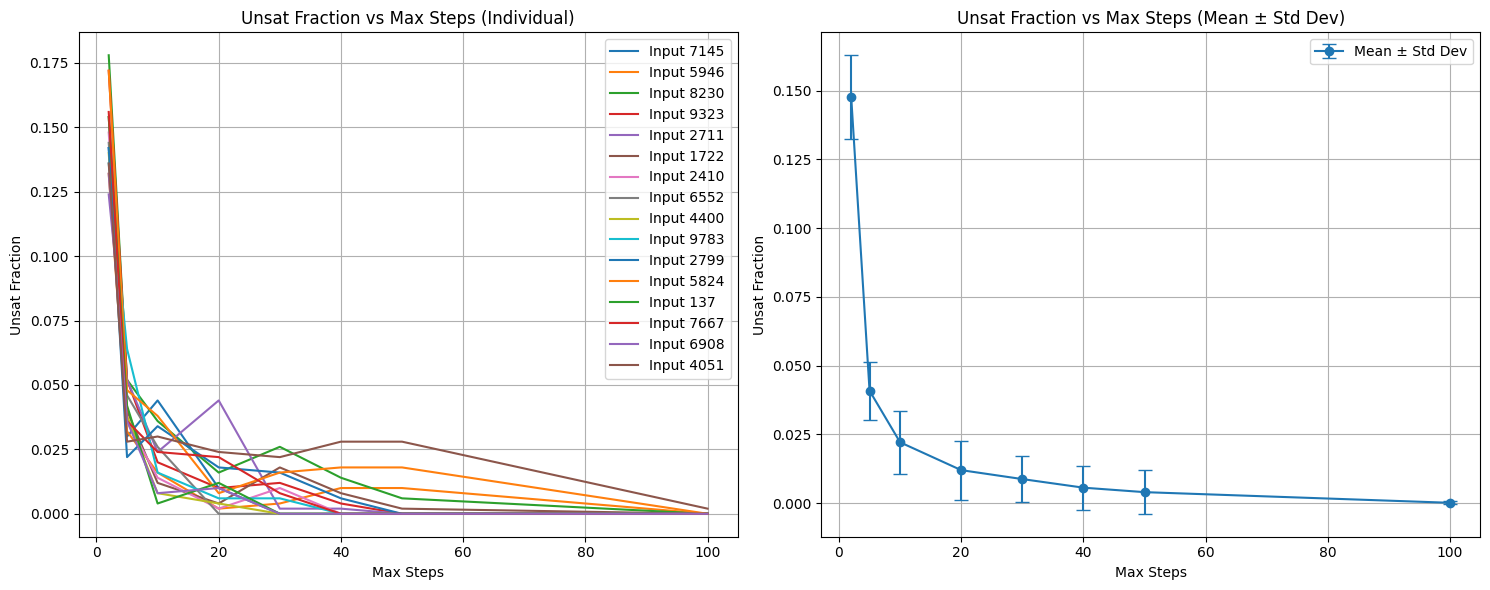

In [ ]:
max_steps_values = [2, 5, 10, 20, 30, 40, 50, 100]
unsat_fractions = []

for steps in max_steps_values:
    state = model.initialize_state(x, y, init_mode)
    reference_final, num_sweeps, unsat = model.relax(state, steps, ignore_right=0)
    unsat_fraction = unsat.mean(dim=-1, dtype=torch.float32).cpu().numpy()
    unsat_fractions.append(unsat_fraction)

# print("Unsat fractions for each max_steps:")
# for steps, fractions in zip(max_steps_values, unsat_fractions):
#     print(f"max_steps={steps:<3}:\n{fractions}")
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# Subplot 1: Individual batch elements
plt.subplot(1, 2, 1)
for b in range(len(unsat_fractions[0])):  # Iterate over batch elements
    plt.plot(
        max_steps_values,
        [unsat_fractions[i][b, 0] for i in range(len(max_steps_values))],
        label=f"Input {idxs[b]}",
    )
plt.xlabel("Max Steps")
plt.ylabel("Unsat Fraction")
plt.title("Unsat Fraction vs Max Steps (Individual)")
plt.legend()
plt.grid(True)

# Subplot 2: Mean and standard deviation
plt.subplot(1, 2, 2)
mean_unsat = [unsat.mean(axis=0)[0] for unsat in unsat_fractions]
std_unsat = [unsat.std(axis=0)[0] for unsat in unsat_fractions]
plt.errorbar(
    max_steps_values,
    mean_unsat,
    yerr=std_unsat,
    fmt="-o",
    capsize=5,
    label="Mean ± Std Dev",
)
plt.xlabel("Max Steps")
plt.ylabel("Unsat Fraction")
plt.title("Unsat Fraction vs Max Steps (Mean ± Std Dev)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

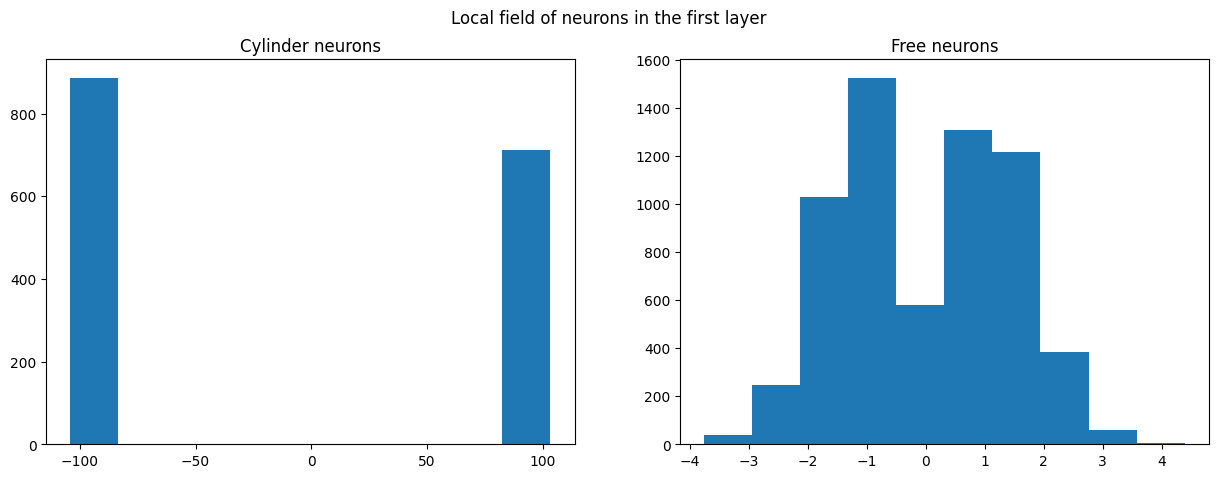

In [ ]:
from matplotlib import pyplot as plt

fields = model.local_field(reference_final, ignore_right=0)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(fields[:, 0, :N].flatten().cpu())
axs[1].hist(fields[:, 0, N:H].flatten().cpu())
fig.suptitle("Local field of neurons in the first layer")
axs[0].set_title("Cylinder neurons")
axs[1].set_title("Free neurons")
plt.show()

In [ ]:
logs = handler.evaluate(x, y, max_steps)
print("Accuracy on batch:")
print(logs["overall_accuracy"])

Accuracy on batch:
0.0625


#### After Learning Step

In [ ]:
state = model.initialize_state(x, y, init_mode)
reference_final, num_sweeps, unsat = model.relax(state, max_steps, ignore_right=0)
made_update = model.perceptron_rule(reference_final)

In [ ]:
state = model.initialize_state(x, y, init_mode)
reference_final, num_sweeps, unsat = model.relax(state, max_steps, ignore_right=0)
_, neurons, readout, _ = model.split_state(reference_final)
label = y.argmax(dim=1)
pred = readout.argmax(dim=1)

print("Fraction usat (B, L+1):")
print(unsat.mean(dim=-1, dtype=torch.float32))

print("\nSimilarity of ferromagnetic cylinder with input (B,):")
print(torch.mean(neurons[:, :, :N] == x.unsqueeze(1), dim=-1, dtype=torch.float32))

print("\nReadout shows correct label (B,):")
print(pred == label)

Fraction usat (B, L+1):
tensor([[6.0e-03, 0.0e+00],
        [1.2e-02, 0.0e+00],
        [2.6e-02, 0.0e+00],
        [1.4e-02, 0.0e+00],
        [3.6e-02, 0.0e+00],
        [3.0e-02, 0.0e+00],
        [2.8e-02, 0.0e+00],
        [3.8e-02, 0.0e+00],
        [2.0e-02, 0.0e+00],
        [2.6e-02, 0.0e+00],
        [1.8e-02, 0.0e+00],
        [2.6e-02, 0.0e+00],
        [3.0e-02, 0.0e+00],
        [2.0e-02, 0.0e+00],
        [2.2e-02, 0.0e+00],
        [3.8e-02, 0.0e+00]], device='mps:0')

Similarity of ferromagnetic cylinder with input (B,):
tensor([[1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00]], device='mps:0')

Readout shows correct label (B,):
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, 

In [ ]:
print("Overlap of Wback prototypes with last layer neurons.")
print("\n-- Correct class --")
correct_overlap_full = (
    torch.einsum(
        "bi,bi->b", model.W_back[:H, label].transpose(0, 1), neurons[:, -1, :H]
    )
    / model.W_back[:H, label].transpose(0, 1).norm(dim=1)
    / neurons[:, -1, :H].norm(dim=1)
)
correct_overlap_free = (
    torch.einsum(
        "bi,bi->b", model.W_back[N:H, label].transpose(0, 1), neurons[:, -1, N:H]
    )
    / model.W_back[N:H, label].transpose(0, 1).norm(dim=1)
    / neurons[:, -1, N:H].norm(dim=1)
)
print("Full layer:")
print(correct_overlap_full)
print("Only free neurons:")
print(correct_overlap_free)

overlaps_full = (
    torch.einsum(
        "ci,bi->bc",
        model.W_back[:H, range(C)].transpose(0, 1),
        neurons[:, -1, :H],
    )
    / model.W_back[:H, range(C)].transpose(0, 1).norm(dim=1)[None, :]
    / neurons[:, -1, :H].norm(dim=1)[:, None]
)
overlaps_free = (
    torch.einsum(
        "ci,bi->bc",
        model.W_back[N:H, range(C)].transpose(0, 1),
        neurons[:, -1, N:H],
    )
    / model.W_back[N:H, range(C)].transpose(0, 1).norm(dim=1)[None, :]
    / neurons[:, -1, N:H].norm(dim=1)[:, None]
)

print("\n-- Wrong classes average --")
idxs_left = [[i] for i in range(len(label))]
idxs_right = [[i for i in range(C) if i != t] for t in label]
print("Full layer:")
print(
    overlaps_full[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)
print("Only free neurons:")
print(
    overlaps_free[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)

print("\n-- Wrong classes --")
print("Full layer:")
print(overlaps_full[idxs_left, idxs_right])
print("Only free neurons:")
print(overlaps_free[idxs_left, idxs_right])

Overlap of Wback prototypes with last layer neurons.

-- Correct class --
Full layer:
tensor([1.2e-01, -8.8e-02, -2.0e-02, 1.5e-02, 5.3e-02, -5.3e-02, -2.9e-02, -5.2e-02, -8.0e-02, 2.5e-02, -4.8e-02, -4.6e-02,
        2.7e-03, 3.7e-02, 2.2e-02, -9.6e-03], device='mps:0')
Only free neurons:
tensor([1.2e-01, -1.1e-01, 1.2e-02, 5.6e-02, 4.0e-02, -7.2e-02, -3.0e-02, -4.2e-02, -1.1e-01, 5.0e-02, -4.6e-02, -3.5e-02,
        -1.4e-02, -2.4e-02, 5.3e-02, -4.8e-02], device='mps:0')

-- Wrong classes average --
Full layer:
tensor([-1.3e-02, -5.1e-03, -1.1e-02, -3.6e-02, 1.1e-02, -1.4e-02, 2.0e-02, -1.5e-02, -1.3e-02, 1.0e-02, -2.3e-02, -1.1e-02,
        1.2e-02, -6.3e-03, 1.4e-02, -1.4e-02], device='mps:0')
Only free neurons:
tensor([-2.2e-02, 5.3e-03, -8.8e-03, -3.4e-02, 7.0e-03, -1.9e-02, 1.9e-02, -2.2e-02, -1.9e-02, 3.9e-03, -2.4e-02, -1.5e-02,
        3.7e-03, -7.5e-03, 6.3e-03, -1.8e-02], device='mps:0')

-- Wrong classes --
Full layer:
tensor([[1.3e-02, -1.1e-02, -6.5e-02, 1.2e-02, 4.8e-02

In [ ]:
print("Overlap of Wforth prototypes with last layer neurons.")
print("\n-- Correct class --")
correct_overlap_full = (
    torch.einsum("bi,bi->b", model.W_forth[label, :H], neurons[:, -1, :H])
    / model.W_forth[label, :H].norm(dim=1)
    / neurons[:, -1, :H].norm(dim=1)
)
correct_overlap_free = (
    torch.einsum("bi,bi->b", model.W_forth[label, N:H], neurons[:, -1, N:H])
    / model.W_forth[label, N:H].norm(dim=1)
    / neurons[:, -1, N:H].norm(dim=1)
)
print("Full layer:")
print(correct_overlap_full)
print("Only free neurons:")
print(correct_overlap_free)

overlaps_full = (
    torch.einsum(
        "ci,bi->bc",
        model.W_forth[range(C), :H],
        neurons[:, -1, :H],
    )
    / model.W_forth[range(C), :H].norm(dim=1)[None, :]
    / neurons[:, -1, :H].norm(dim=1)[:, None]
)
overlaps_free = (
    torch.einsum(
        "ci,bi->bc",
        model.W_forth[range(C), N:H],
        neurons[:, -1, N:H],
    )
    / model.W_forth[range(C), N:H].norm(dim=1)[None, :]
    / neurons[:, -1, N:H].norm(dim=1)[:, None]
)
print("\n-- Wrong classes average --")
idxs_left = [[i] for i in range(len(label))]
idxs_right = [[i for i in range(C) if i != t] for t in label]
print("Full layer:")
print(
    overlaps_full[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)
print("Only free neurons:")
print(
    overlaps_free[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)

print("\n-- Wrong classes --")
print("Full layer:")
print(overlaps_full[idxs_left, idxs_right])
print("Only free neurons:")
print(overlaps_free[idxs_left, idxs_right])

Overlap of Wforth prototypes with last layer neurons.

-- Correct class --
Full layer:
tensor([-4.2e-02, -6.9e-02, -1.7e-01, -1.9e-01, 1.1e-01, -2.0e-01, -1.0e-01, -1.7e-01, -2.4e-01, -8.6e-02, -8.0e-02, -8.9e-02,
        -1.1e-01, -9.4e-02, -1.4e-01, -1.2e-01], device='mps:0')
Only free neurons:
tensor([-2.4e-02, -7.0e-02, -1.2e-01, -1.4e-01, 1.2e-01, -2.1e-01, -9.8e-02, -1.5e-01, -2.4e-01, -4.2e-02, -4.3e-02, -4.6e-02,
        -9.6e-02, -1.2e-01, -9.2e-02, -1.2e-01], device='mps:0')

-- Wrong classes average --
Full layer:
tensor([-3.1e-01, -1.9e-01, -2.7e-01, -3.8e-01, -1.5e-01, -2.9e-01, -3.0e-01, -3.1e-01, -3.0e-01, -2.7e-01, -2.9e-01, -2.3e-01,
        -2.2e-01, -2.9e-01, -3.0e-01, -2.5e-01], device='mps:0')
Only free neurons:
tensor([-2.9e-01, -1.7e-01, -2.4e-01, -3.6e-01, -1.3e-01, -2.8e-01, -2.9e-01, -2.9e-01, -2.9e-01, -2.5e-01, -2.6e-01, -2.0e-01,
        -2.0e-01, -2.6e-01, -2.8e-01, -2.3e-01], device='mps:0')

-- Wrong classes --
Full layer:
tensor([[-3.2e-01, -3.1e-01, -2

In [ ]:
print("Logits magnitude.")
print("\n-- Correct class --")
correct_overlap_full = torch.einsum(
    "bi,bi->b", model.W_forth[label, :H], neurons[:, -1, :H]
)
correct_overlap_free = torch.einsum(
    "bi,bi->b", model.W_forth[label, N:H], neurons[:, -1, N:H]
)
print("Full layer:")
print(correct_overlap_full)
print("Only free neurons:")
print(correct_overlap_free)

overlaps_full = torch.einsum(
    "ci,bi->bc", model.W_forth[range(C), :H], neurons[:, -1, :H]
)
overlaps_free = torch.einsum(
    "ci,bi->bc", model.W_forth[range(C), N:H], neurons[:, -1, N:H]
)
print("\n-- Wrong classes average --")
idxs_left = [[i] for i in range(len(label))]
idxs_right = [[i for i in range(C) if i != t] for t in label]
print("Full layer:")
print(
    overlaps_full[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)
print("Only free neurons:")
print(
    overlaps_free[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)

print("\n-- Wrong classes --")
print("Full layer:")
print(overlaps_full[idxs_left, idxs_right])
print("Only free neurons:")
print(overlaps_free[idxs_left, idxs_right])

Logits magnitude.

-- Correct class --
Full layer:
tensor([-1.1e+00, -2.0e+00, -4.9e+00, -5.3e+00, 3.3e+00, -5.7e+00, -3.0e+00, -4.8e+00, -6.7e+00, -2.4e+00, -2.3e+00, -2.5e+00,
        -3.1e+00, -2.6e+00, -3.8e+00, -3.4e+00], device='mps:0')
Only free neurons:
tensor([-4.9e-01, -1.5e+00, -2.7e+00, -3.1e+00, 2.7e+00, -4.6e+00, -2.2e+00, -3.3e+00, -5.2e+00, -9.1e-01, -9.8e-01, -1.0e+00,
        -2.1e+00, -2.5e+00, -2.0e+00, -2.7e+00], device='mps:0')

-- Wrong classes average --
Full layer:
tensor([-8.7e+00, -5.5e+00, -7.6e+00, -1.1e+01, -4.1e+00, -8.0e+00, -8.4e+00, -8.7e+00, -8.5e+00, -7.7e+00,
        -8.2e+00, -6.5e+00, -6.2e+00, -8.2e+00, -8.5e+00, -7.0e+00],
       device='mps:0')
Only free neurons:
tensor([-6.5e+00, -3.7e+00, -5.3e+00, -7.8e+00, -2.9e+00, -6.0e+00, -6.3e+00, -6.4e+00, -6.3e+00, -5.6e+00, -5.7e+00, -4.4e+00,
        -4.4e+00, -5.8e+00, -6.2e+00, -5.1e+00], device='mps:0')

-- Wrong classes --
Full layer:
tensor([[-9.0e+00, -8.6e+00, -8.0e+00, -8.5e+00, -8.2e+00, -

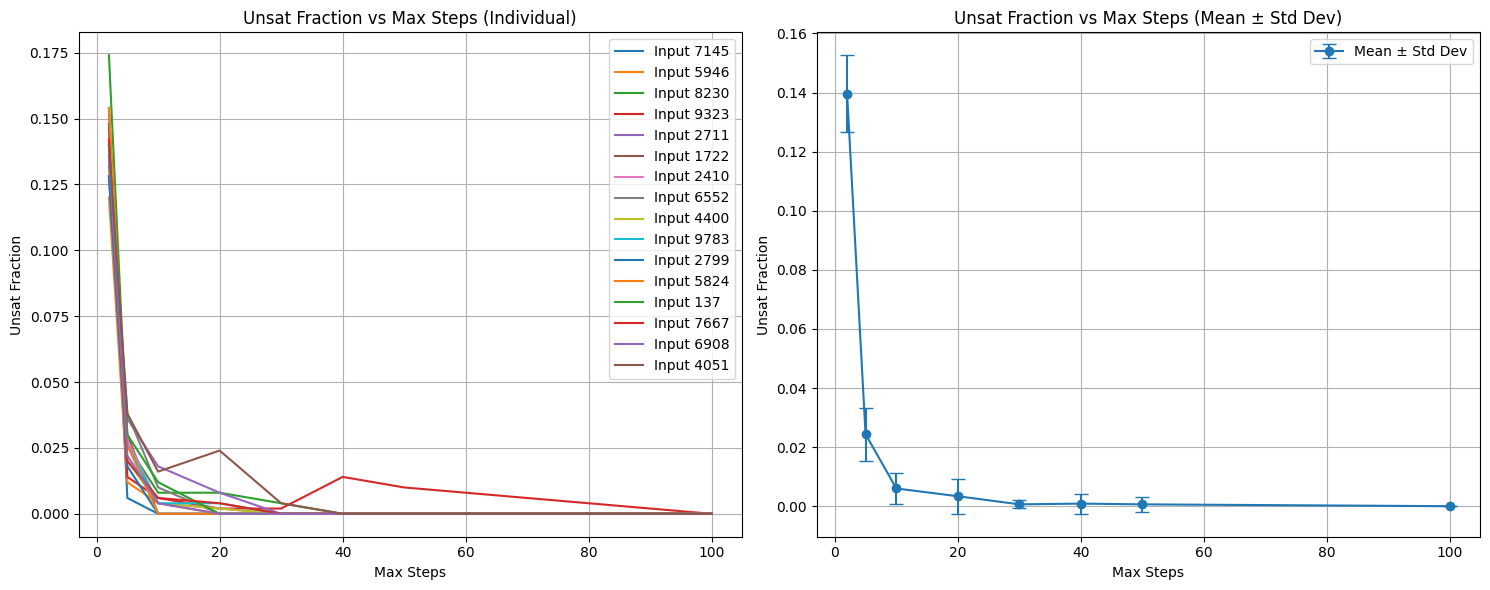

In [ ]:
max_steps_values = [2, 5, 10, 20, 30, 40, 50, 100]
unsat_fractions = []

for steps in max_steps_values:
    state = model.initialize_state(x, y, init_mode)
    reference_final, num_sweeps, unsat = model.relax(state, steps, ignore_right=0)
    unsat_fraction = unsat.mean(dim=-1, dtype=torch.float32).cpu().numpy()
    unsat_fractions.append(unsat_fraction)

# print("Unsat fractions for each max_steps:")
# for steps, fractions in zip(max_steps_values, unsat_fractions):
#     print(f"max_steps={steps:<3}:\n{fractions}")
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# Subplot 1: Individual batch elements
plt.subplot(1, 2, 1)
for b in range(len(unsat_fractions[0])):  # Iterate over batch elements
    plt.plot(
        max_steps_values,
        [unsat_fractions[i][b, 0] for i in range(len(max_steps_values))],
        label=f"Input {idxs[b]}",
    )
plt.xlabel("Max Steps")
plt.ylabel("Unsat Fraction")
plt.title("Unsat Fraction vs Max Steps (Individual)")
plt.legend()
plt.grid(True)

# Subplot 2: Mean and standard deviation
plt.subplot(1, 2, 2)
mean_unsat = [unsat.mean(axis=0)[0] for unsat in unsat_fractions]
std_unsat = [unsat.std(axis=0)[0] for unsat in unsat_fractions]
plt.errorbar(
    max_steps_values,
    mean_unsat,
    yerr=std_unsat,
    fmt="-o",
    capsize=5,
    label="Mean ± Std Dev",
)
plt.xlabel("Max Steps")
plt.ylabel("Unsat Fraction")
plt.title("Unsat Fraction vs Max Steps (Mean ± Std Dev)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

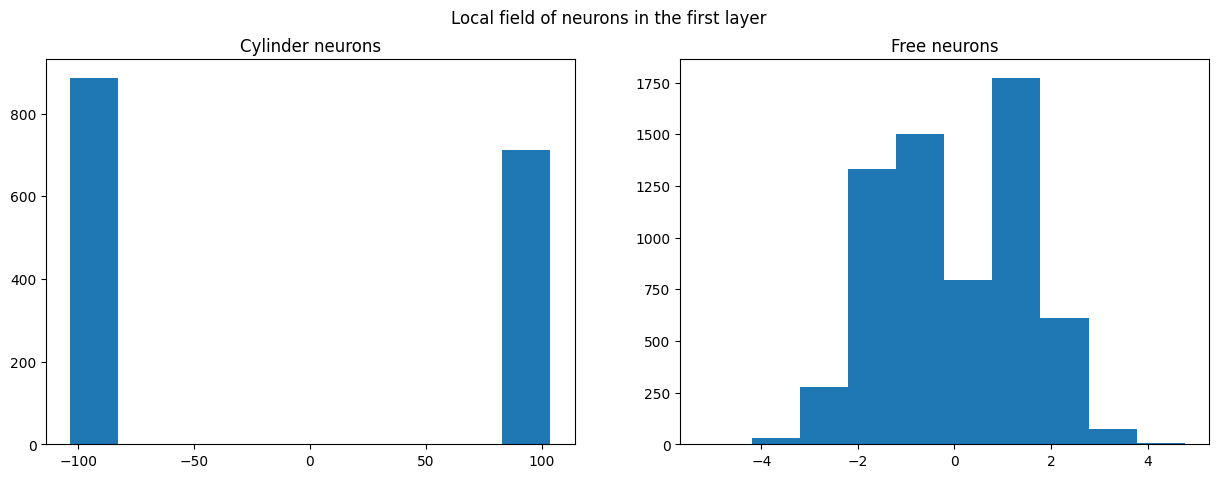

In [ ]:
from matplotlib import pyplot as plt

fields = model.local_field(reference_final, ignore_right=0)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(fields[:, 0, :N].flatten().cpu())
axs[1].hist(fields[:, 0, N:H].flatten().cpu())
fig.suptitle("Local field of neurons in the first layer")
axs[0].set_title("Cylinder neurons")
axs[1].set_title("Free neurons")
plt.show()

In [ ]:
logs = handler.evaluate(x, y, max_steps)
print("Accuracy on batch:")
print(logs["overall_accuracy"])

Accuracy on batch:
0.9375


### Train Loop

In [ ]:
# # for i in range(H):
# #     model.couplings[0, i, H + i] = 100

# # num_epochs = 35

# threshold = torch.tensor([1.75, 7.5])
# lr = torch.tensor([0.0075, 0.0, 0.1])
# weight_decay = torch.tensor([0.0025, 0.0, 0.005])
# model.prepare_tensors(
#     threshold=threshold,
#     lr=lr,
#     weight_decay=weight_decay,
# )

In [ ]:
logs = handler.train_loop(
    num_epochs,
    train_inputs,
    train_targets,
    max_steps,
    batch_size,
    eval_interval=eval_interval,
    eval_inputs=eval_inputs,
    eval_targets=eval_targets,
)

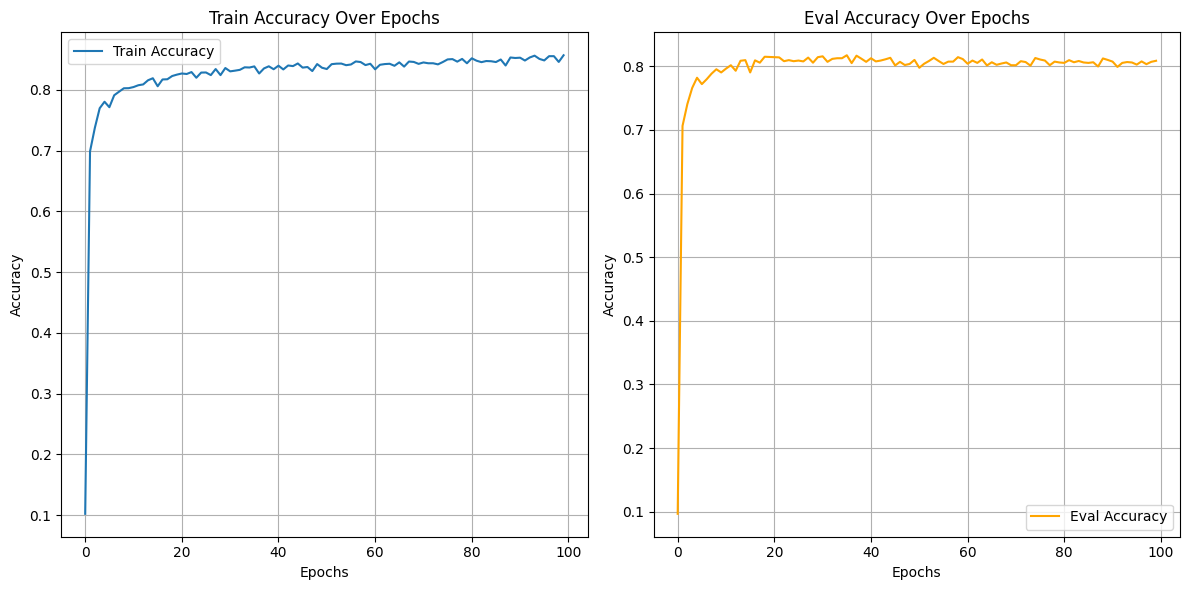

In [ ]:
from matplotlib import pyplot as plt

train_accs = logs["train_acc_history"]
eval_accs = logs["eval_acc_history"]

plt.figure(figsize=(12, 6))

# Subplot 1: Train accuracy
plt.subplot(1, 2, 1)
plt.plot(range(len(train_accs)), train_accs, label="Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train Accuracy Over Epochs")
plt.legend()
plt.grid(True)

# Subplot 2: Eval accuracy
plt.subplot(1, 2, 2)
plt.plot(range(len(eval_accs)), eval_accs, label="Eval Accuracy", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Eval Accuracy Over Epochs")
plt.legend()
plt.grid(True)

# Save the figure to disk
plt.tight_layout()
# plt.savefig("accuracy_fisso.png")
plt.show()

Final Train Accuracy: 0.85


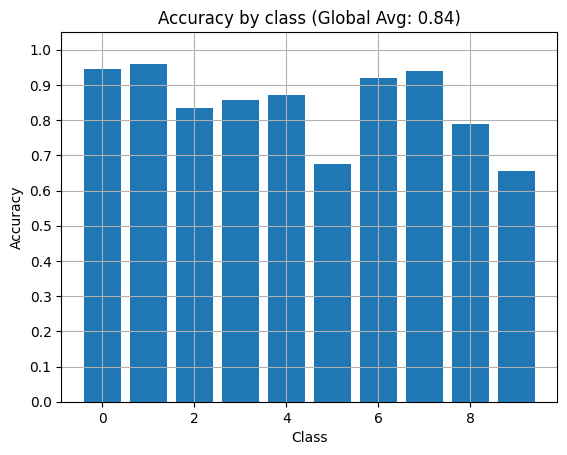

In [ ]:
import matplotlib.pyplot as plt

from src.utils import plot_accuracy_by_class_barplot

train_metrics = handler.evaluate(train_inputs, train_targets, max_steps)
print(f"Final Train Accuracy: {train_metrics['overall_accuracy']:.2f}")
fig = plot_accuracy_by_class_barplot(train_metrics["accuracy_by_class"])
plt.show()

Final Eval Accuracy: 0.81


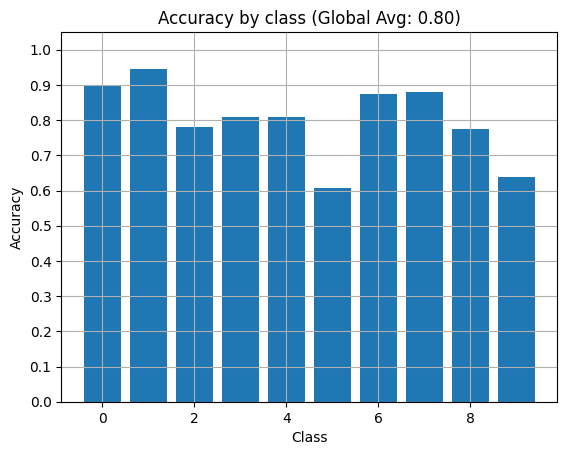

In [ ]:
import matplotlib.pyplot as plt

from src.utils import plot_accuracy_by_class_barplot

eval_metrics = handler.evaluate(eval_inputs, eval_targets, max_steps)
print(f"Final Eval Accuracy: {eval_metrics['overall_accuracy']:.2f}")
fig = plot_accuracy_by_class_barplot(eval_metrics["accuracy_by_class"])
plt.show()

In [ ]:
out = model.inference(eval_inputs, max_steps)
logits = out[0]
predictions = torch.argmax(logits, dim=1)
gt = torch.argmax(eval_targets, dim=1)

In [ ]:
import torch.nn.functional as F

probas = F.softmax(logits, dim=1)
probas_wrong = probas[gt != predictions]
probas_right = probas[gt == predictions]

diff_wrong = (
    (
        probas_wrong.topk(2, dim=1).values[:, 0]
        - probas_wrong.topk(2, dim=1).values[:, 1]
    )
    .mean()
    .item()
)
diff_right = (
    (
        probas_right.topk(2, dim=1).values[:, 0]
        - probas_right.topk(2, dim=1).values[:, 1]
    )
    .mean()
    .item()
)

print(f"Average difference (wrong predictions): {diff_wrong}")
print(f"Average difference (correct predictions): {diff_right}")

Average difference (wrong predictions): 0.8208250999450684
Average difference (correct predictions): 0.9707291722297668


In [ ]:
proba_of_gt_wrong = probas_wrong[range(probas_wrong.size(0)), gt[gt != predictions]]
avg_proba_of_gt_wrong = proba_of_gt_wrong.mean().item()
print(
    f"Average probability of correct ground truth class among probas_wrong: {avg_proba_of_gt_wrong}"
)

Average probability of correct ground truth class among probas_wrong: 0.05344800278544426


In [ ]:
proba_of_gt_right = probas_right[range(probas_right.size(0)), gt[gt == predictions]]
avg_proba_of_gt_right = proba_of_gt_right.mean().item()
print(
    f"Average probability of correct ground truth class among probas_right: {avg_proba_of_gt_right}"
)

Average probability of correct ground truth class among probas_right: 0.9847245812416077


In [ ]:
logs = handler.train_epoch(
    train_inputs,
    train_targets,
    max_steps,
    batch_size,
)
out = handler.evaluate(train_inputs, train_targets, max_steps)
is_correct = out["logits"].argmax(dim=1) == train_targets.argmax(dim=1)
print("Accuracy:", is_correct.mean(dtype=torch.float32).float().item())
for i in range(C):
    print(
        f"Class {i}: {is_correct[train_targets[:, i] == 1].mean(dtype=torch.float32):.2f}"
    )

Accuracy: 0.878333330154419
Class 0: 0.97
Class 1: 0.98
Class 2: 0.85
Class 3: 0.83
Class 4: 0.90
Class 5: 0.77
Class 6: 0.94
Class 7: 0.91
Class 8: 0.80
Class 9: 0.80


In [ ]:
train_labels = train_targets.argmax(dim=1)
idxs = train_labels == 8
x = train_inputs[idxs]
y = train_targets[idxs]

In [ ]:
logs = handler.train_epoch(
    x,
    y,
    max_steps,
    batch_size,
)
out = handler.evaluate(train_inputs, train_targets, max_steps)
is_correct = out["logits"].argmax(dim=1) == train_targets.argmax(dim=1)
print("Accuracy:", is_correct.mean(dtype=torch.float32).float().item())
for i in range(C):
    print(
        f"Class {i}: {is_correct[train_targets[:, i] == 1].mean(dtype=torch.float32):.2f}"
    )

Accuracy: 0.6548333168029785
Class 0: 0.88
Class 1: 0.83
Class 2: 0.50
Class 3: 0.34
Class 4: 0.71
Class 5: 0.20
Class 6: 0.80
Class 7: 0.80
Class 8: 0.99
Class 9: 0.41


### Fields

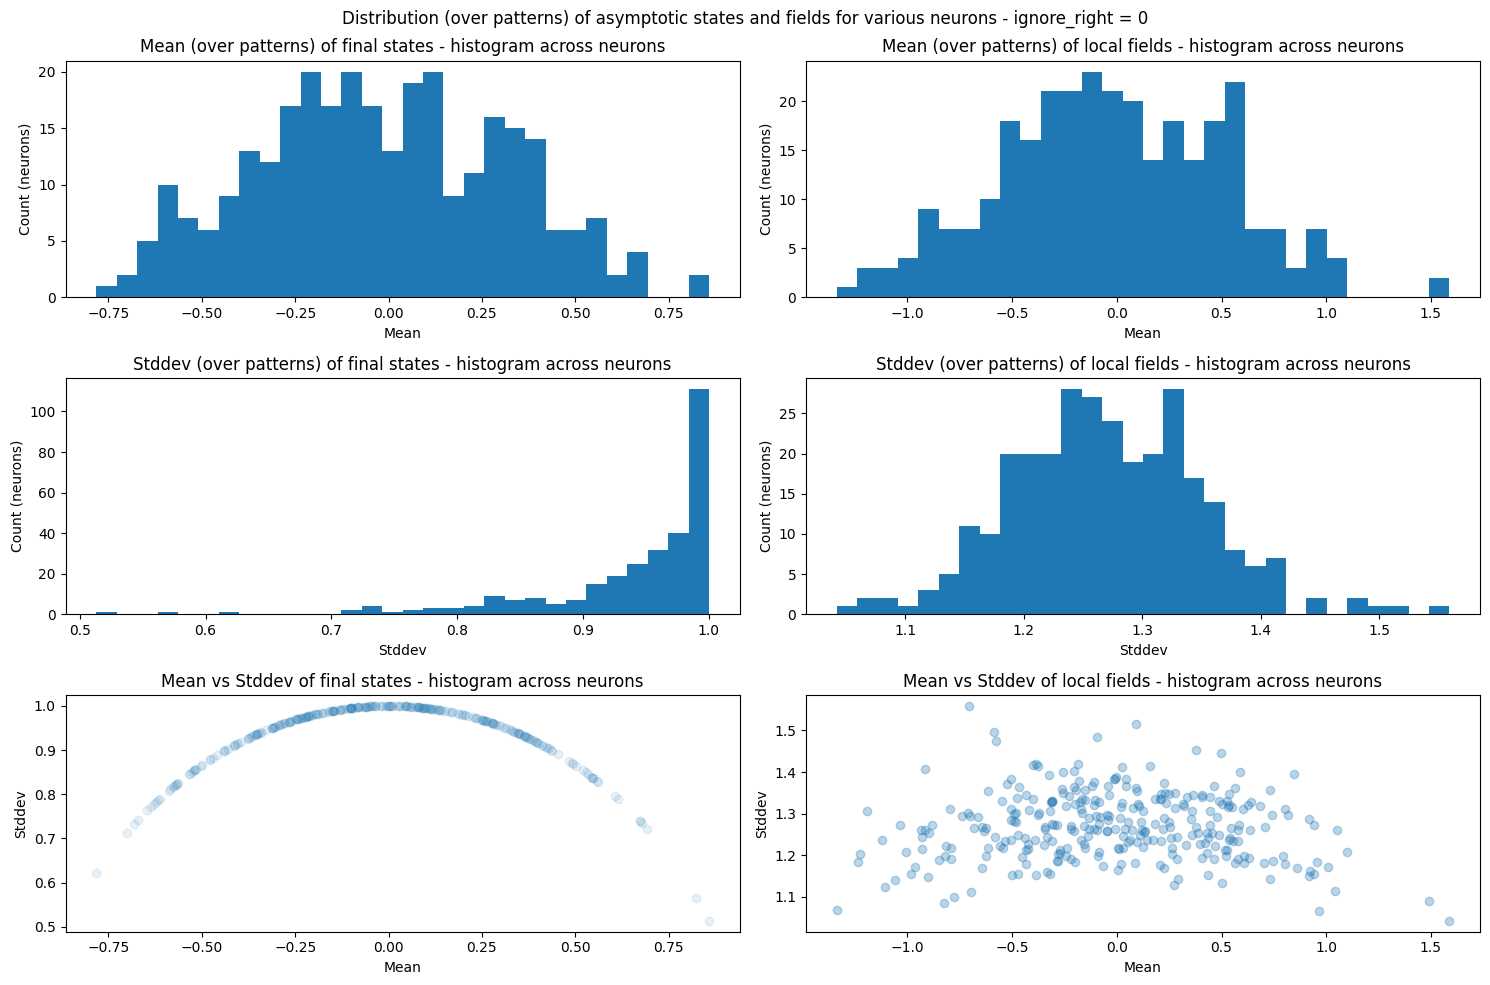

In [ ]:
ignore_right = 0

from matplotlib import pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(15, 10))

states = model.initialize_state(train_inputs, train_targets, init_mode)
final_states, _, unsat = model.relax(states, max_steps, ignore_right=ignore_right)
fields = model.local_field(final_states, ignore_right=ignore_right)
states_means = final_states[:, 1:-2, N:].mean(dim=0).flatten().cpu()
states_stds = final_states[:, 1:-2, N:].std(dim=0).flatten().cpu()
fields_means = fields[:, :-1, N:].mean(dim=0).flatten().cpu()
fields_stds = fields[:, :-1, N:].std(dim=0).flatten().cpu()
ax = axs[0, 0]
ax.hist(states_means, bins=30)
ax.set_title("Mean (over patterns) of final states - histogram across neurons")
ax.set_xlabel("Mean")
ax.set_ylabel("Count (neurons)")
ax = axs[1, 0]
ax.hist(states_stds, bins=30)
ax.set_title("Stddev (over patterns) of final states - histogram across neurons")
ax.set_xlabel("Stddev")
ax.set_ylabel("Count (neurons)")
ax = axs[2, 0]
ax.scatter(states_means, states_stds, alpha=0.1)
ax.set_title("Mean vs Stddev of final states - histogram across neurons")
ax.set_xlabel("Mean")
ax.set_ylabel("Stddev")
ax = axs[0, 1]
ax.hist(fields_means, bins=30)
ax.set_title("Mean (over patterns) of local fields - histogram across neurons")
ax.set_xlabel("Mean")
ax.set_ylabel("Count (neurons)")
ax = axs[1, 1]
ax.hist(fields_stds, bins=30)
ax.set_title("Stddev (over patterns) of local fields - histogram across neurons")
ax.set_xlabel("Stddev")
ax.set_ylabel("Count (neurons)")
ax = axs[2, 1]
ax.scatter(fields_means, fields_stds, alpha=0.3)
ax.set_title("Mean vs Stddev of local fields - histogram across neurons")
ax.set_xlabel("Mean")
ax.set_ylabel("Stddev")

fig.suptitle(
    f"Distribution (over patterns) of asymptotic states and fields for various neurons - ignore_right = {ignore_right}"
)
plt.tight_layout()
plt.show()

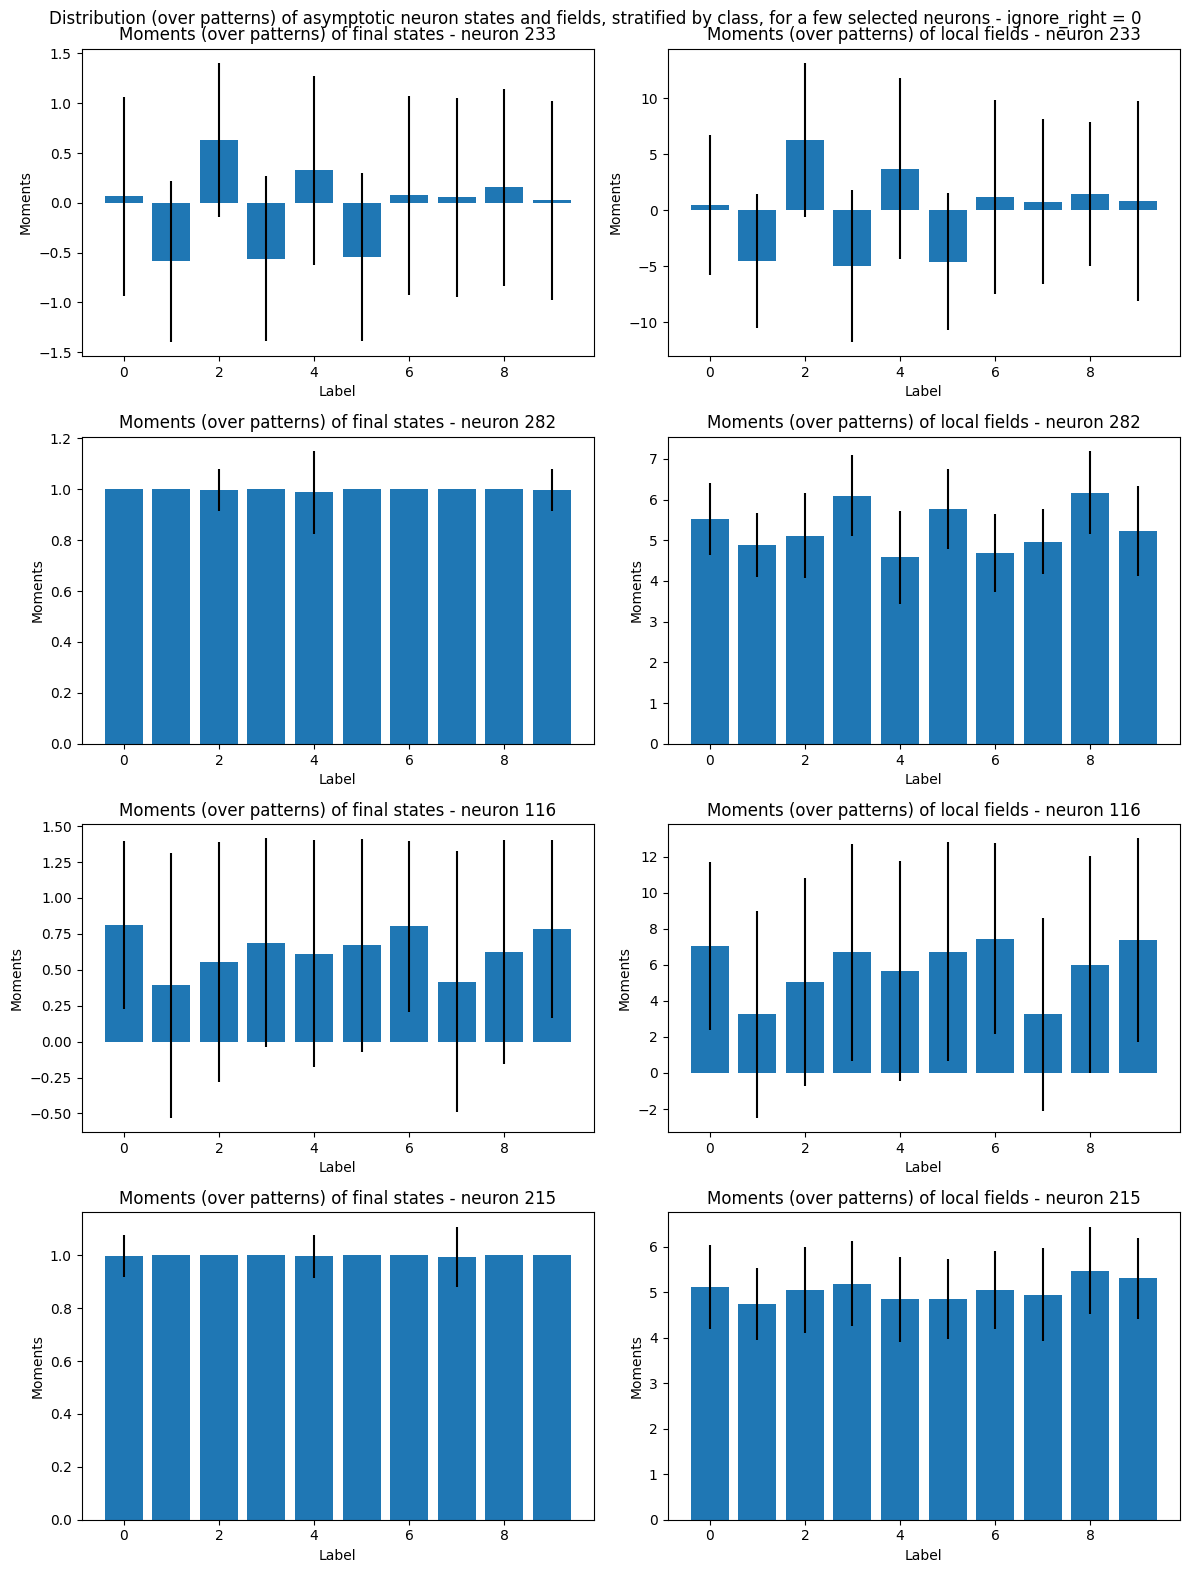

In [ ]:
import numpy as np

nrows = 4
fig, axs = plt.subplots(nrows, 2, figsize=(12, 4 * nrows))
neuron_idxs = np.random.randint(0, H - N, nrows)

ignore_right = 0
states = model.initialize_state(train_inputs, train_targets, init_mode)
final_states, _, unsat = model.relax(states, max_steps, ignore_right=ignore_right)
fields = model.local_field(final_states, ignore_right=ignore_right)

labels = train_targets.argmax(dim=1)
means_states, stds_states, means_fields, stds_fields = [], [], [], []
for c in range(C):
    mean = final_states[labels == c, 1:-2, N:].mean(dim=0).flatten().cpu()
    std = final_states[labels == c, 1:-2, N:].std(dim=0).flatten().cpu()
    means_states.append(mean)
    stds_states.append(std)
    mean = fields[labels == c, :-1, N:].mean(dim=0).flatten().cpu()
    std = fields[labels == c, :-1, N:].std(dim=0).flatten().cpu()
    means_fields.append(mean)
    stds_fields.append(std)
means_states = np.array(means_states)
stds_states = np.array(stds_states)
means_fields = np.array(means_fields)
stds_fields = np.array(stds_fields)
for i, idx in enumerate(neuron_idxs):
    ax = axs[i, 0]
    ax.bar(range(len(means_states)), means_states[:, idx], yerr=stds_states[:, idx])
    ax.set_title(f"Moments (over patterns) of final states - neuron {idx}")
    ax.set_xlabel("Label")
    ax.set_ylabel("Moments")

    ax = axs[i, 1]
    ax.bar(range(len(means_fields)), means_fields[:, idx], yerr=stds_fields[:, idx])
    ax.set_title(f"Moments (over patterns) of local fields - neuron {idx}")
    ax.set_xlabel("Label")
    ax.set_ylabel("Moments")
fig.suptitle(
    f"Distribution (over patterns) of asymptotic neuron states and fields, stratified by class, for a few selected neurons - ignore_right = {ignore_right}"
)
plt.tight_layout()
plt.show()

In [ ]:
logs = handler.train_epoch(
    train_inputs,
    train_targets,
    max_steps,
    batch_size,
)
out = handler.evaluate(train_inputs, train_targets, max_steps)
is_correct = out["logits"].argmax(dim=1) == train_targets.argmax(dim=1)
print("Accuracy:", is_correct.mean(dtype=torch.float32).float().item())
for i in range(C):
    print(
        f"Class {i}: {is_correct[train_targets[:, i] == 1].mean(dtype=torch.float32):.2f}"
    )

Accuracy: 0.8296666741371155
Class 0: 0.93
Class 1: 0.96
Class 2: 0.73
Class 3: 0.87
Class 4: 0.81
Class 5: 0.66
Class 6: 0.92
Class 7: 0.86
Class 8: 0.72
Class 9: 0.81


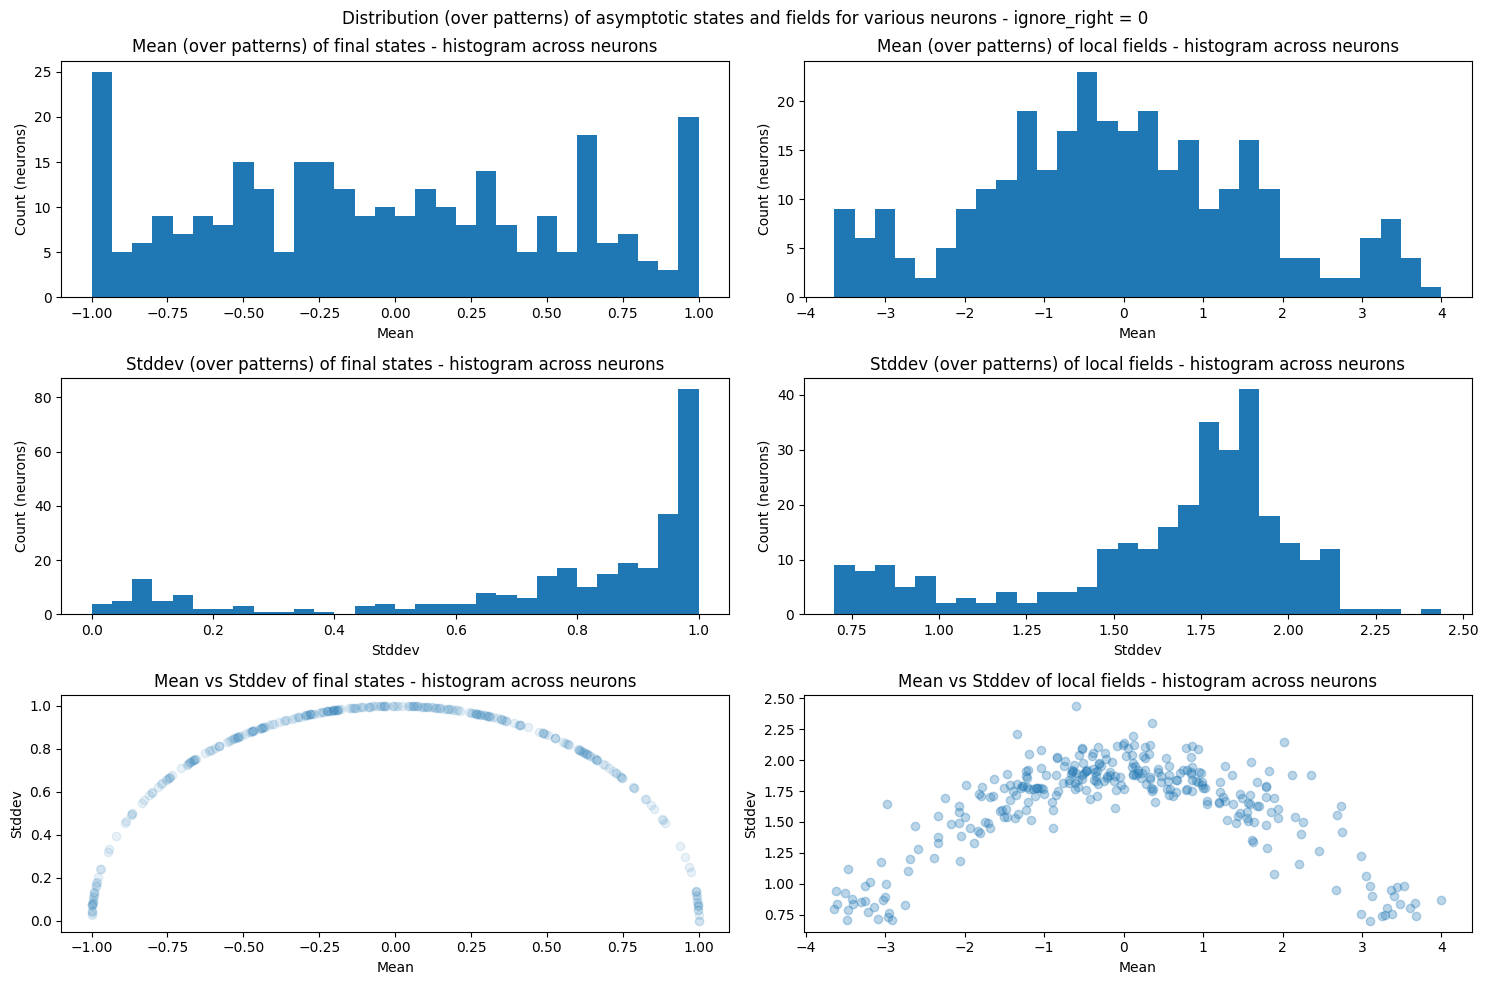

In [ ]:
from matplotlib import pyplot as plt

ignore_right = 0
fig, axs = plt.subplots(3, 2, figsize=(15, 10))

states = model.initialize_state(train_inputs, train_targets, init_mode)
final_states, _, unsat = model.relax(states, max_steps, ignore_right=ignore_right)
fields = model.local_field(final_states, ignore_right=ignore_right)
states_means = final_states[:, 1:-2, N:].mean(dim=0).flatten().cpu()
states_stds = final_states[:, 1:-2, N:].std(dim=0).flatten().cpu()
fields_means = fields[:, :-1, N:].mean(dim=0).flatten().cpu()
fields_stds = fields[:, :-1, N:].std(dim=0).flatten().cpu()
ax = axs[0, 0]
ax.hist(states_means, bins=30)
ax.set_title("Mean (over patterns) of final states - histogram across neurons")
ax.set_xlabel("Mean")
ax.set_ylabel("Count (neurons)")
ax = axs[1, 0]
ax.hist(states_stds, bins=30)
ax.set_title("Stddev (over patterns) of final states - histogram across neurons")
ax.set_xlabel("Stddev")
ax.set_ylabel("Count (neurons)")
ax = axs[2, 0]
ax.scatter(states_means, states_stds, alpha=0.1)
ax.set_title("Mean vs Stddev of final states - histogram across neurons")
ax.set_xlabel("Mean")
ax.set_ylabel("Stddev")
ax = axs[0, 1]
ax.hist(fields_means, bins=30)
ax.set_title("Mean (over patterns) of local fields - histogram across neurons")
ax.set_xlabel("Mean")
ax.set_ylabel("Count (neurons)")
ax = axs[1, 1]
ax.hist(fields_stds, bins=30)
ax.set_title("Stddev (over patterns) of local fields - histogram across neurons")
ax.set_xlabel("Stddev")
ax.set_ylabel("Count (neurons)")
ax = axs[2, 1]
ax.scatter(fields_means, fields_stds, alpha=0.3)
ax.set_title("Mean vs Stddev of local fields - histogram across neurons")
ax.set_xlabel("Mean")
ax.set_ylabel("Stddev")

fig.suptitle(
    f"Distribution (over patterns) of asymptotic states and fields for various neurons - ignore_right = {ignore_right}"
)
plt.tight_layout()
plt.show()

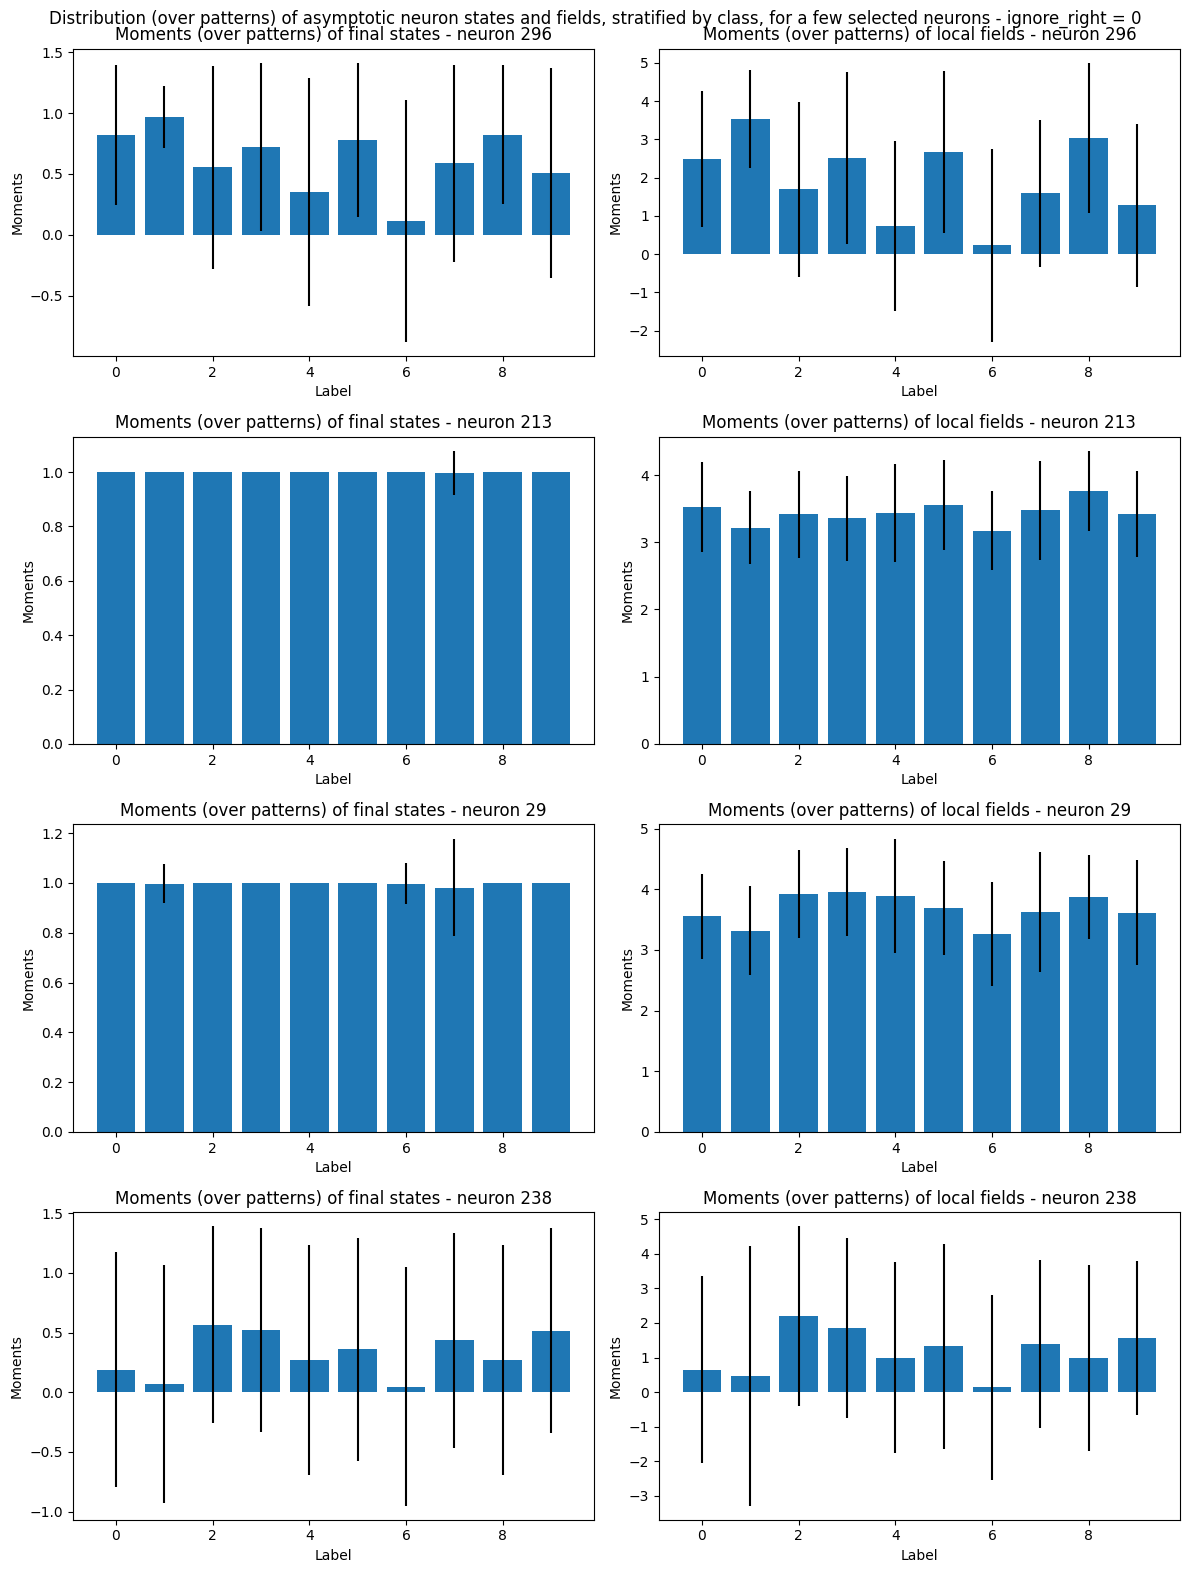

In [ ]:
import numpy as np

nrows = 4
fig, axs = plt.subplots(nrows, 2, figsize=(12, 4 * nrows))
neuron_idxs = np.random.randint(0, H - N, nrows)

ignore_right = 0
states = model.initialize_state(train_inputs, train_targets, init_mode)
final_states, _, unsat = model.relax(states, max_steps, ignore_right=ignore_right)
fields = model.local_field(final_states, ignore_right=ignore_right)

labels = train_targets.argmax(dim=1)
means_states, stds_states, means_fields, stds_fields = [], [], [], []
for c in range(C):
    mean = final_states[labels == c, 1:-2, N:].mean(dim=0).flatten().cpu()
    std = final_states[labels == c, 1:-2, N:].std(dim=0).flatten().cpu()
    means_states.append(mean)
    stds_states.append(std)
    mean = fields[labels == c, :-1, N:].mean(dim=0).flatten().cpu()
    std = fields[labels == c, :-1, N:].std(dim=0).flatten().cpu()
    means_fields.append(mean)
    stds_fields.append(std)
means_states = np.array(means_states)
stds_states = np.array(stds_states)
means_fields = np.array(means_fields)
stds_fields = np.array(stds_fields)
for i, idx in enumerate(neuron_idxs):
    ax = axs[i, 0]
    ax.bar(range(len(means_states)), means_states[:, idx], yerr=stds_states[:, idx])
    ax.set_title(f"Moments (over patterns) of final states - neuron {idx}")
    ax.set_xlabel("Label")
    ax.set_ylabel("Moments")

    ax = axs[i, 1]
    ax.bar(range(len(means_fields)), means_fields[:, idx], yerr=stds_fields[:, idx])
    ax.set_title(f"Moments (over patterns) of local fields - neuron {idx}")
    ax.set_xlabel("Label")
    ax.set_ylabel("Moments")
fig.suptitle(
    f"Distribution (over patterns) of asymptotic neuron states and fields, stratified by class, for a few selected neurons - ignore_right = {ignore_right}"
)
plt.tight_layout()
plt.show()

### Relaxation

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

max_sweeps = 50

#### Field annealing

In [ ]:
idxs = torch.randint(0, len(train_inputs), (16,)).tolist()
x = train_inputs[idxs]
y = train_targets[idxs]
state = model.initialize_state(x, y, init_mode)

In [ ]:
def double_relaxation(model, state, max_sweeps):
    sweeps = 0
    while sweeps < max_sweeps:
        fields = model.local_field(state, ignore_right=0)
        state[:, 1:-1, :] = torch.sign(fields)
        sweeps += 1
    fields = model.local_field(state, ignore_right=0)
    first_unsat = state[:, 1:-1, :] != torch.sign(fields)
    first_fixed_point = state.clone()
    while sweeps < 2 * max_sweeps:
        fields = model.local_field(state, ignore_right=3)
        state[:, 1:-1, :] = torch.sign(fields)
        sweeps += 1
    fields = model.local_field(state, ignore_right=3)
    second_unsat = state[:, 1:-1, :] != torch.sign(fields)
    return first_fixed_point, state, first_unsat, second_unsat

In [ ]:
first_fixed_point, second_fixed_point, first_unsat, second_unsat = double_relaxation(
    model, state, max_sweeps
)

In [ ]:
first_unsat.mean(dim=(1, 2), dtype=torch.float32)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='mps:0')

In [ ]:
second_unsat.mean(dim=(1, 2), dtype=torch.float32)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='mps:0')

In [ ]:
(first_fixed_point == second_fixed_point)[:, 1, :].mean(dim=-1, dtype=torch.float32)

tensor([0.9625, 1.0000, 1.0000, 1.0000, 0.9975, 0.9950, 0.9850, 1.0000, 0.9725,
        0.8975, 0.9775, 1.0000, 0.9575, 0.8200, 1.0000, 1.0000],
       device='mps:0')

In [ ]:
first_logits = first_fixed_point[:, 1, :] @ model.W_forth.T
second_logits = second_fixed_point[:, 1, :] @ model.W_forth.T

In [ ]:
first_logits.argmax(dim=1) == second_logits.argmax(dim=1)

tensor([False,  True,  True,  True,  True,  True, False,  True,  True,  True,
        False,  True,  True,  True,  True,  True], device='mps:0')

#### Trajectory

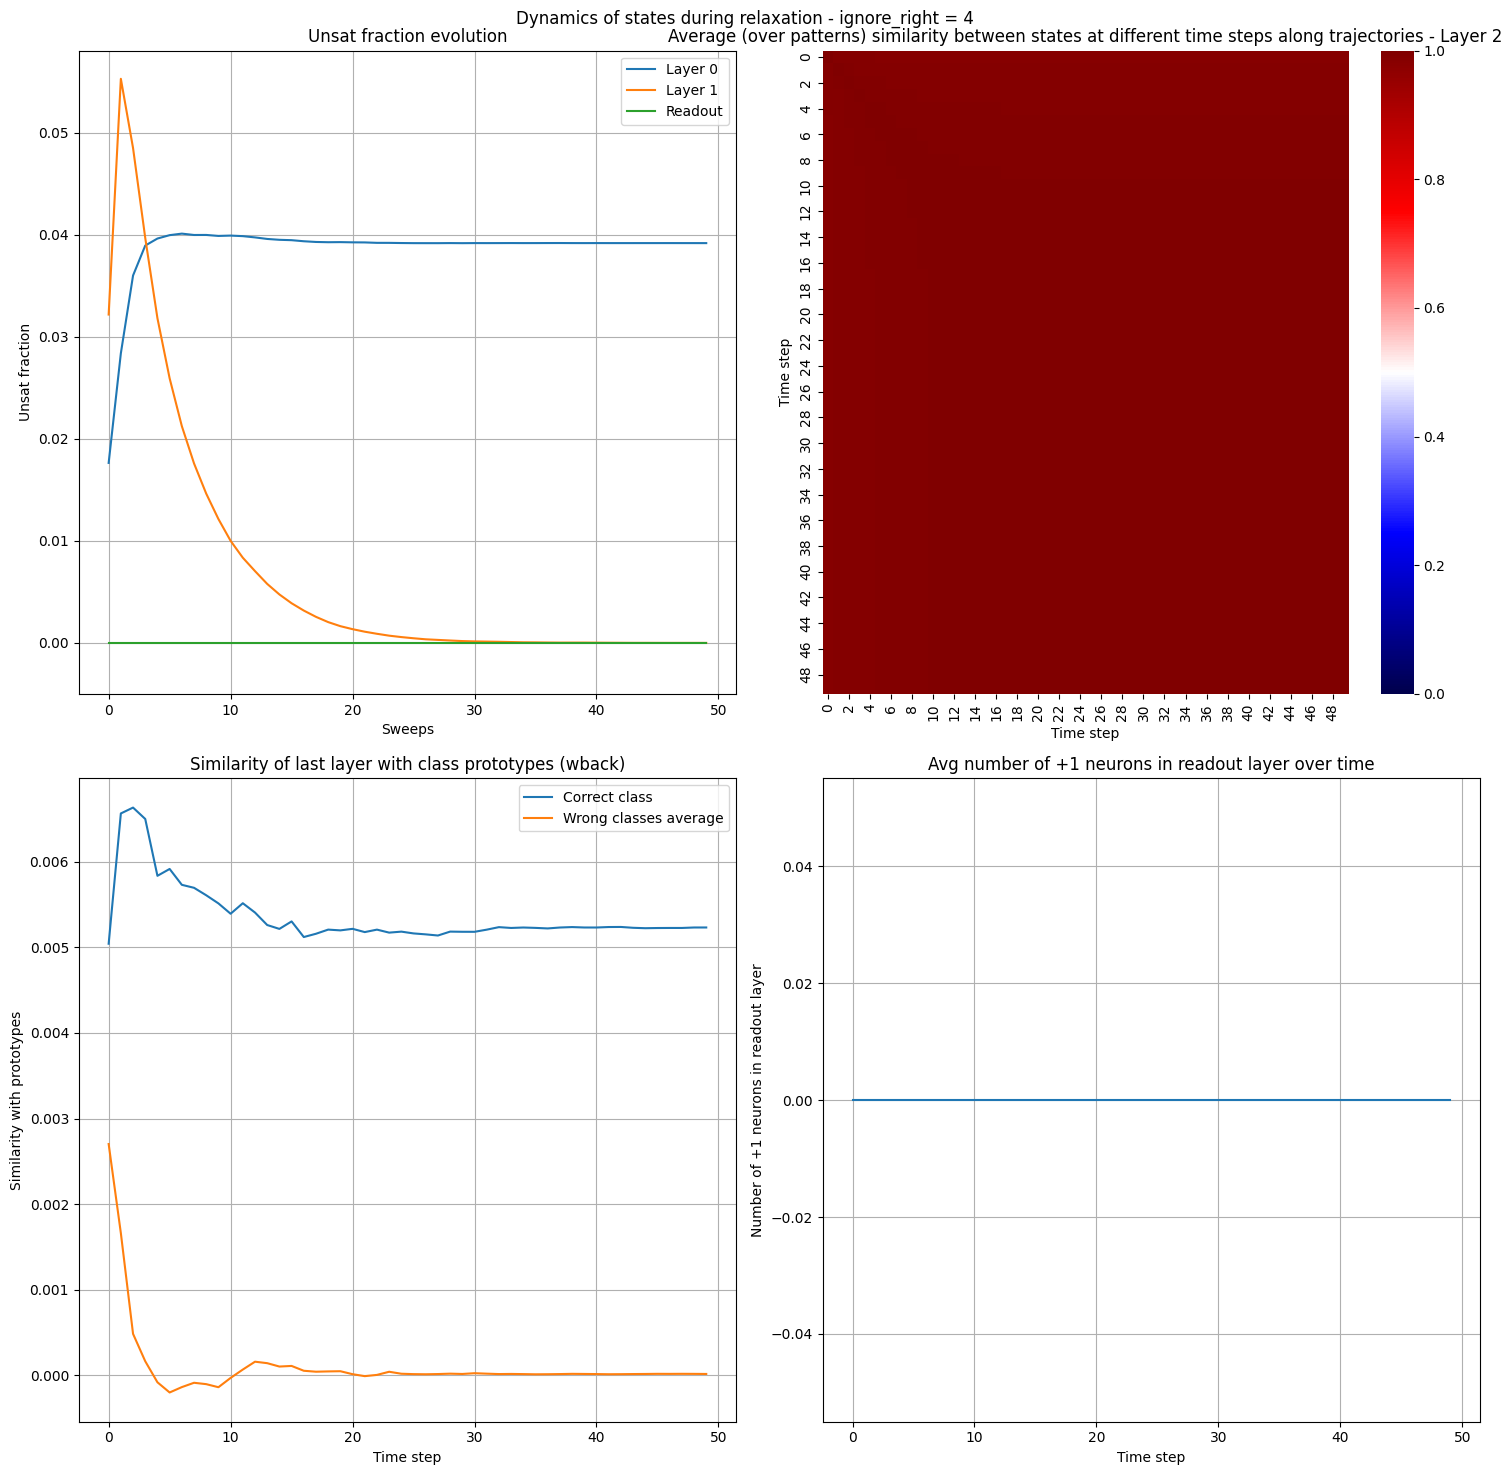

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), sharey=False)


ignore_right = 4
states, unsats = handler.relaxation_trajectory(
    train_inputs, train_targets, max_sweeps, ignore_right=ignore_right
)
# unsat evolution
unsat_evolution = unsats[:, :, :, :].mean(dim=(0, -1), dtype=torch.float32).cpu()
ax = axs[0, 0]
for l in range(num_layers + 1):
    ax.plot(unsat_evolution[:, l], label=f"Layer {l}" if l < num_layers else "Readout")
ax.set_xlabel("Sweeps")
ax.set_ylabel("Unsat fraction")
ax.set_title("Unsat fraction evolution")
ax.grid()
ax.legend()
ax.set_ylim(-0.005)
# heatmap of similarities between different timesteps' states
B, T, L, H = states.shape
similarities = torch.zeros((L - 2, T, T))
for t1 in range(T):
    for t2 in range(T):
        sims = (states[:, t1, 1:-1, :] == states[:, t2, 1:-1, :]).mean(
            dim=(0, 2), dtype=torch.float32
        )  # (L,). exclude readout
        similarities[:, t1, t2] = sims.cpu()
ax = axs[0, 1]
l = 0
sns.heatmap(
    similarities[l, :, :],
    ax=ax,
    cmap="seismic",
    vmin=0,
    vmax=1,
    label=f"Layer {l}" if l < num_layers else "Readout",
)
ax.set_xlabel("Time step")
ax.set_ylabel("Time step")
ax.set_title(
    f"Average (over patterns) similarity between states at different time steps along trajectories - Layer {l}"
)
# similarity with class prototypes (columns of W_back)
ax = axs[1, 0]
similarities = torch.zeros((2, T))
for t in range(T):
    labels = train_targets.argmax(dim=1)
    sims_correct = torch.nn.functional.cosine_similarity(
        states[:, t, -3, :], model.W_back[:, labels].T, dim=-1
    ).mean(dim=0, dtype=torch.float32)
    similarities[0, t] = sims_correct

    sims_wrong = []
    for shift in range(1, C):
        labels_shifted = (labels + shift) % C
        sims_shifted = torch.nn.functional.cosine_similarity(
            states[:, t, -3, :], model.W_back[:, labels_shifted].T, dim=-1
        ).mean(dim=0, dtype=torch.float32)
        sims_wrong.append(sims_shifted)
    similarities[1, t] = torch.mean(torch.stack(sims_wrong), dim=0)
ax.plot(similarities[0, :], label="Correct class")
ax.plot(similarities[1, :], label="Wrong classes average")
ax.set_xlabel("Time step")
ax.set_ylabel("Similarity with prototypes")
ax.set_title("Similarity of last layer with class prototypes (wback)")
ax.grid()
ax.legend()
# number of +1 neurons in readout layer
ax = axs[1, 1]
number_ones_readout = (
    (states[:, :, -2, :C] == 1).sum(dim=-1).mean(dim=0, dtype=torch.float32).cpu()
)  # (T,)
ax.plot(number_ones_readout)
ax.set_xlabel("Time step")
ax.set_ylabel("Number of +1 neurons in readout layer")
ax.set_title("Avg number of +1 neurons in readout layer over time")
ax.grid()

fig.suptitle(f"Dynamics of states during relaxation - ignore_right = {ignore_right}")
plt.tight_layout()
plt.show()

In [ ]:
logs = handler.train_epoch(
    train_inputs,
    train_targets,
    max_steps,
    batch_size,
)
out = handler.evaluate(train_inputs, train_targets, max_steps)
is_correct = out["logits"].argmax(dim=1) == train_targets.argmax(dim=1)
print("Accuracy:", is_correct.mean(dtype=torch.float32).float().item())
for i in range(C):
    print(
        f"Class {i}: {is_correct[train_targets[:, i] == 1].mean(dtype=torch.float32):.2f}"
    )

Accuracy: 0.7041666507720947
Class 0: 0.92
Class 1: 0.93
Class 2: 0.75
Class 3: 0.70
Class 4: 0.79
Class 5: 0.32
Class 6: 0.85
Class 7: 0.86
Class 8: 0.43
Class 9: 0.41


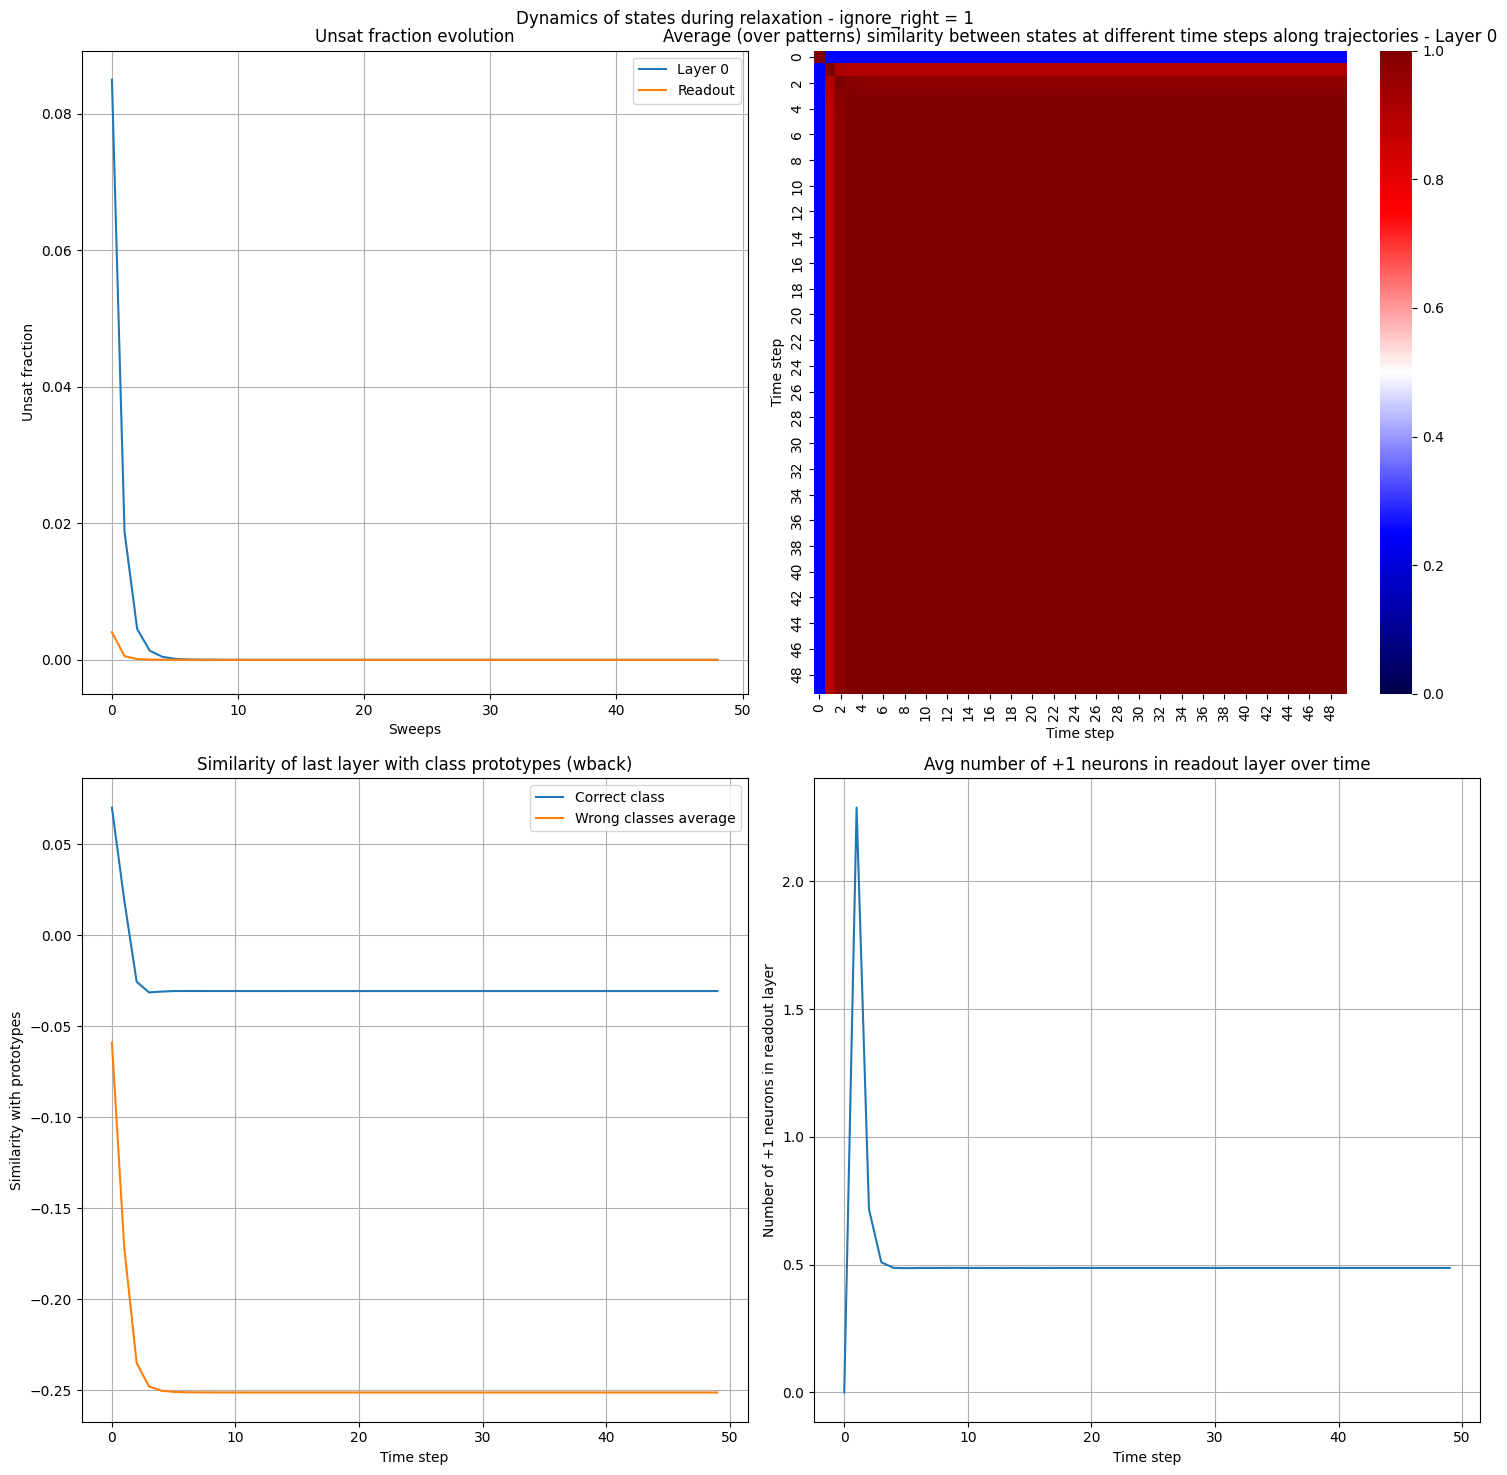

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), sharey=False)


ignore_right = 1
states, unsats = handler.relaxation_trajectory(
    train_inputs, train_targets, max_sweeps, ignore_right=ignore_right
)
# unsat evolution
unsat_evolution = unsats[:, 1:, :, :].mean(dim=(0, -1), dtype=torch.float32).cpu()
ax = axs[0, 0]
for l in range(num_layers + 1):
    ax.plot(unsat_evolution[:, l], label=f"Layer {l}" if l < num_layers else "Readout")
ax.set_xlabel("Sweeps")
ax.set_ylabel("Unsat fraction")
ax.set_title("Unsat fraction evolution")
ax.grid()
ax.legend()
ax.set_ylim(-0.005)
# heatmap of similarities between different timesteps' states
B, T, L, H = states.shape
similarities = torch.zeros((L, T, T))
for t1 in range(T):
    for t2 in range(T):
        sims = (states[:, t1, 1:-2, :] == states[:, t2, 1:-2, :]).mean(
            dim=(0, -1), dtype=torch.float32
        )  # (L,). exclude readout
        similarities[:, t1, t2] = sims.cpu()
ax = axs[0, 1]
l = 1
sns.heatmap(
    similarities[l, :, :],
    ax=ax,
    cmap="seismic",
    vmin=0,
    vmax=1,
    label=f"Layer {l}" if l < num_layers else "Readout",
)
ax.set_xlabel("Time step")
ax.set_ylabel("Time step")
ax.set_title(
    "Average (over patterns) similarity between states at different time steps along trajectories - Layer 0"
)
# similarity with class prototypes (columns of W_back)
ax = axs[1, 0]
similarities = torch.zeros((2, T))
for t in range(T):
    labels = train_targets.argmax(dim=1)
    sims_correct = torch.nn.functional.cosine_similarity(
        states[:, t, -3, :], model.W_back[:, labels].T, dim=-1
    ).mean(dim=0, dtype=torch.float32)
    similarities[0, t] = sims_correct

    sims_wrong = []
    for shift in range(1, C):
        labels_shifted = (labels + shift) % C
        sims_shifted = torch.nn.functional.cosine_similarity(
            states[:, t, -3, :], model.W_back[:, labels_shifted].T, dim=-1
        ).mean(dim=0, dtype=torch.float32)
        sims_wrong.append(sims_shifted)
    similarities[1, t] = torch.mean(torch.stack(sims_wrong), dim=0)
ax.plot(similarities[0, :], label="Correct class")
ax.plot(similarities[1, :], label="Wrong classes average")
ax.set_xlabel("Time step")
ax.set_ylabel("Similarity with prototypes")
ax.set_title("Similarity of last layer with class prototypes (wback)")
ax.grid()
ax.legend()
# number of +1 neurons in readout layer
ax = axs[1, 1]
number_ones_readout = (
    (states[:, :, -2, :C] == 1).sum(dim=-1).mean(dim=0, dtype=torch.float32).cpu()
)  # (T,)
ax.plot(number_ones_readout)
ax.set_xlabel("Time step")
ax.set_ylabel("Number of +1 neurons in readout layer")
ax.set_title("Avg number of +1 neurons in readout layer over time")
ax.grid()

fig.suptitle(f"Dynamics of states during relaxation - ignore_right = {ignore_right}")
plt.tight_layout()
plt.show()

### Input ordering

In [ ]:
from matplotlib import pyplot as plt


def gaussian_kernel(window_size, sigma):
    """
    Generate a Gaussian kernel with the given window size and standard deviation.
    """
    kernel = torch.arange(window_size).float()
    kernel = kernel - (window_size - 1) / 2
    kernel = torch.exp(-0.5 * (kernel / sigma) ** 2)
    kernel = kernel / kernel.sum()
    return kernel


def bin_array(array, k):
    """
    Split the array into k consecutive chunks and compute the mean of each bin.
    """
    chunk_size = len(array) // k
    binned_array = []
    for i in range(k):
        start = i * chunk_size
        end = (i + 1) * chunk_size if i != k - 1 else len(array)
        binned_array.append(array[start:end].mean(dtype=torch.float32))
    return binned_array


idxs_perm = torch.randperm(len(train_inputs))
train_inputs_perm = train_inputs[idxs_perm]
train_targets_perm = train_targets[idxs_perm]

out = handler.evaluate(train_inputs_perm, train_targets_perm, max_steps)
is_correct = out["logits"].argmax(dim=1) == train_targets.argmax(dim=1)
print(is_correct.mean(dtype=torch.float32))

tensor(0.0982, device='mps:0')


In [ ]:
logs = handler.train_epoch(
    train_inputs_perm,
    train_targets_perm,
    max_steps,
    batch_size,
    False,
)

In [ ]:
out = handler.evaluate(train_inputs_perm, train_targets_perm, max_steps)
is_correct = out["logits"].argmax(dim=1) == train_targets_perm.argmax(dim=1)
print("Accuracy:", is_correct.mean(dtype=torch.float32).float().item())
for i in range(C):
    print(
        f"Class {i}: {is_correct[train_targets_perm[:, i] == 1].mean(dtype=torch.float32):.2f}"
    )

Accuracy: 0.7080000042915344
Class 0: 0.92
Class 1: 0.97
Class 2: 0.67
Class 3: 0.62
Class 4: 0.77
Class 5: 0.49
Class 6: 0.82
Class 7: 0.85
Class 8: 0.54
Class 9: 0.35


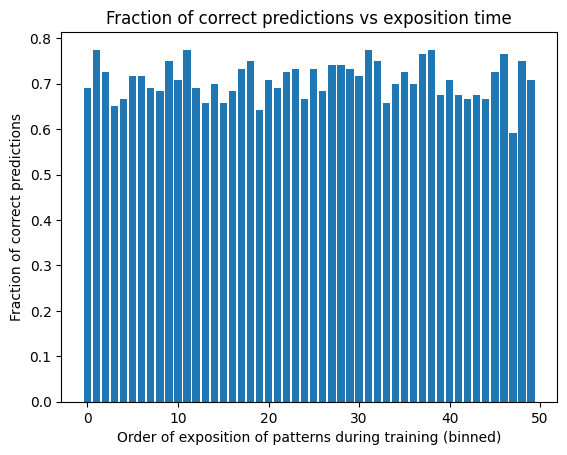

In [ ]:
k = 50
binned_array = bin_array(is_correct.cpu(), k)
plt.bar(range(len(binned_array)), binned_array)
plt.xlabel("Order of exposition of patterns during training (binned)")
plt.ylabel("Fraction of correct predictions")
plt.title("Fraction of correct predictions vs exposition time")
plt.show()

Smoothing with: tensor([0.0161, 0.0436, 0.0924, 0.1523, 0.1956, 0.1956, 0.1523, 0.0924, 0.0436,
        0.0161])


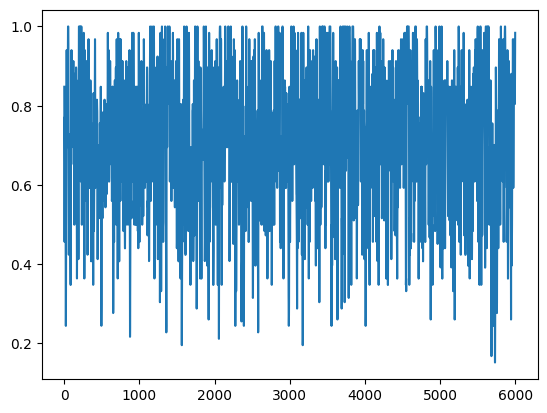

In [ ]:
from matplotlib import pyplot as plt

window_size = 10
sigma = window_size / 5
window = gaussian_kernel(window_size, sigma)
print("Smoothing with:", window)
is_correct_reflected = torch.cat(
    [
        torch.tensor([is_correct[0]] * (window_size // 2)),
        is_correct.cpu(),
        torch.tensor([is_correct[-1]] * (window_size // 2)),
    ],
    dim=0,
)
is_correct_smoothed = torch.nn.functional.conv1d(
    is_correct_reflected.float().unsqueeze(0).unsqueeze(0),
    window.unsqueeze(0).unsqueeze(0),
)[0, 0]
plt.plot(is_correct_smoothed)
plt.show()

Smoothing with: tensor([0.0036, 0.0054, 0.0077, 0.0107, 0.0146, 0.0192, 0.0247, 0.0308, 0.0374,
        0.0442, 0.0508, 0.0568, 0.0617, 0.0652, 0.0671, 0.0671, 0.0652, 0.0617,
        0.0568, 0.0508, 0.0442, 0.0374, 0.0308, 0.0247, 0.0192, 0.0146, 0.0107,
        0.0077, 0.0054, 0.0036])


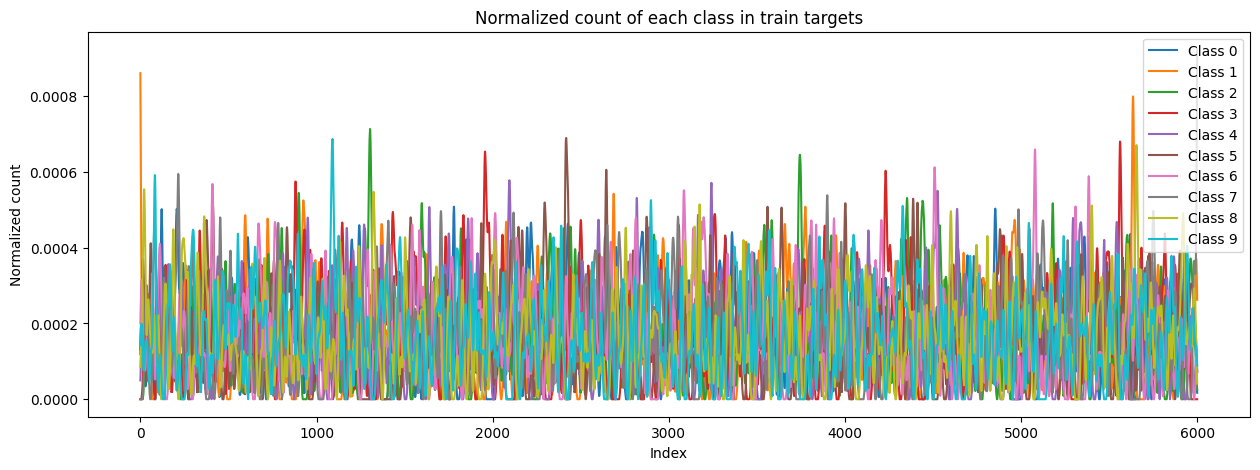

In [ ]:
# # make a scatter plot. each dot should correspond to an element of train_targets_perm. its color should depend on the class of the element. the x value should be the index of the element in train_targets_perm.
# plt.figure(figsize=(15, 5))
# plt.scatter(
#     range(len(train_targets_perm)),
#     train_targets_perm.argmax(dim=1).cpu(),
#     c=train_targets_perm.argmax(dim=1).cpu(),
#     cmap="viridis",
# )
# plt.colorbar()
# plt.xlabel("Index")
# plt.ylabel("Class")
# plt.title("Scatter plot of train targets")
# plt.show()

window_size = 30
sigma = window_size / 5
window = gaussian_kernel(window_size, sigma)
print("Smoothing with:", window)

plt.figure(figsize=(15, 5))
for i in range(C):
    binary_vector = (train_targets_perm.argmax(dim=1) == i).float()
    normalized_vector = binary_vector / binary_vector.sum()
    normalized_vector_reflected = torch.cat(
        [
            torch.tensor([normalized_vector[0]] * (window_size // 2)),
            normalized_vector.cpu(),
            torch.tensor([normalized_vector[-1]] * (window_size // 2)),
        ],
        dim=0,
    )
    smoothed_vector = torch.nn.functional.conv1d(
        normalized_vector_reflected.float().unsqueeze(0).unsqueeze(0),
        window.unsqueeze(0).unsqueeze(0),
    )[0, 0]
    plt.plot(smoothed_vector, label=f"Class {i}")
plt.xlabel("Index")
plt.ylabel("Normalized count")
plt.title("Normalized count of each class in train targets")
plt.legend()
plt.show()

### Couplings

In [ ]:
print("couplings projecting to free neurons from input (cylinder neurons)\n")
print(
    model.couplings[0, N:, H : H + N],
    f"shape: {model.couplings[0, N:, H : H + N].shape}",
)
print("\n\n")
print("internal couplings between free neurons\n")
print(
    model.couplings[0, N:, H + N : 2 * H],
    f"shape: {model.couplings[0, N:, H + N : 2 * H].shape}",
)
# print()
# # internal couplings between cylinder neurons --> never updated (except weight decay, but they have no effect anyways)
# print(
#     model.couplings[0, :N, H : H + N],
#     f"shape: {model.couplings[0, :N, H : H + N].shape}",
# )
# print()
# # couplings from free neurons to cylinder neurons --> never updated (except weight decay, but they have no effect anyways)
# print(
#     model.couplings[0, :N, H + N : 2 * H],
#     f"shape: {model.couplings[0, :N, H + N : 2 * H].shape}",
# )

couplings projecting to free neurons from input (cylinder neurons)

tensor([[ 0.0851,  0.0798, -0.0192,  ..., -0.0231,  0.0088,  0.0273],
        [ 0.0482, -0.0020,  0.0567,  ...,  0.0997,  0.0095, -0.0473],
        [-0.0205, -0.0517, -0.0209,  ..., -0.0019, -0.0309,  0.0061],
        ...,
        [ 0.0428,  0.0788,  0.1000,  ...,  0.1031,  0.0025, -0.0569],
        [-0.1337,  0.0182,  0.0318,  ..., -0.0444, -0.0446, -0.0245],
        [ 0.0376,  0.0081,  0.0470,  ...,  0.0268,  0.0538, -0.0284]],
       device='mps:0') shape: torch.Size([300, 100])



internal couplings between free neurons

tensor([[ 0.3000, -0.0490,  0.0061,  ...,  0.0425,  0.0027,  0.0369],
        [ 0.0081,  0.3000,  0.0076,  ...,  0.0869,  0.0317,  0.0024],
        [-0.0155, -0.0165,  0.3000,  ...,  0.0115, -0.0005, -0.0505],
        ...,
        [-0.0100,  0.0554, -0.0332,  ...,  0.3000,  0.0048, -0.0753],
        [-0.0197, -0.0319, -0.0451,  ...,  0.0044,  0.3000, -0.0406],
        [-0.0439,  0.0496, -0.0206,  .

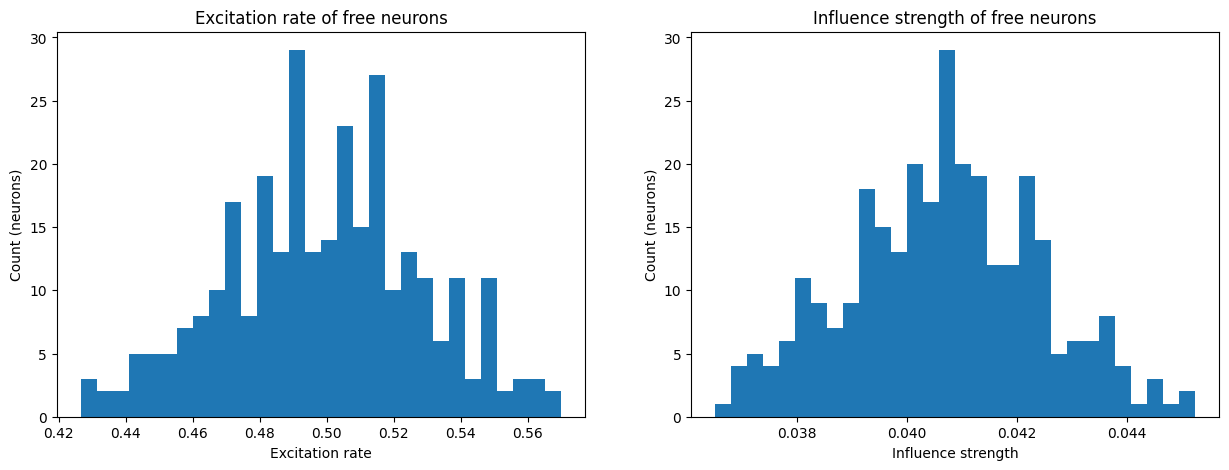

In [ ]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, ncols=2, figsize=(15, 5))

# fraction of positive outgoing (internal) couplings for each free neuron
excitation_rates = (model.couplings[0, N:, H + N : 2 * H] > 0).mean(
    dim=0, dtype=torch.float32
)
# average magnitude of outgoing (internal) couplings for each free neuron
influence_strengths = model.couplings[0, N:, H + N : 2 * H].abs().mean(dim=0)
ax = axs[0]
ax.hist(excitation_rates.cpu(), bins=30)
ax.set_xlabel("Excitation rate")
ax.set_ylabel("Count (neurons)")
ax.set_title("Excitation rate of free neurons")
ax = axs[1]
ax.hist(influence_strengths.cpu(), bins=30)
ax.set_xlabel("Influence strength")
ax.set_ylabel("Count (neurons)")
ax.set_title("Influence strength of free neurons")
plt.show()

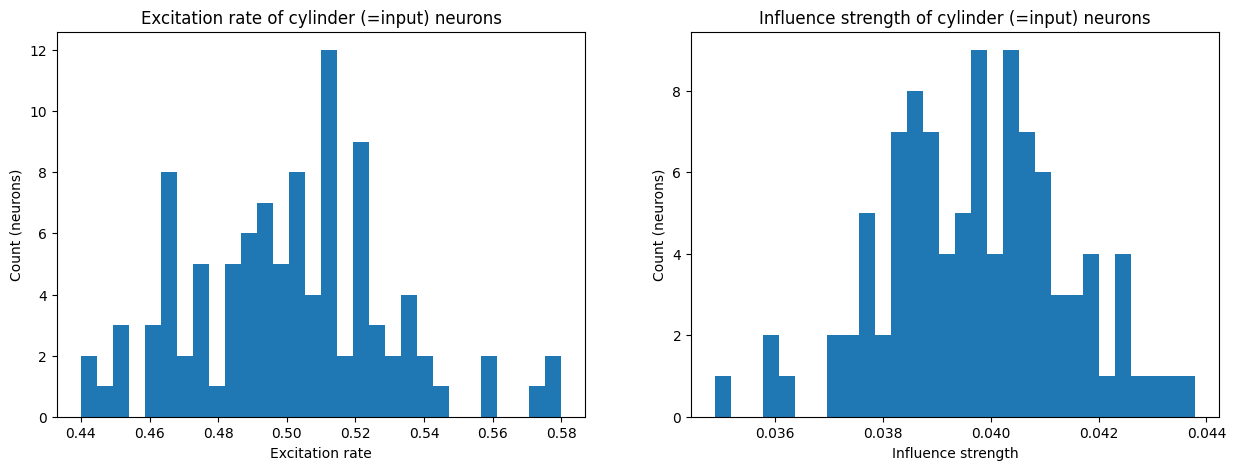

In [ ]:
fig, axs = plt.subplots(1, ncols=2, figsize=(15, 5))

# fraction of positive outgoing couplings for each cylinder neuron
excitation_rates = (model.couplings[0, N:, H : H + N] > 0).mean(
    dim=0, dtype=torch.float32
)
# average magnitude of outgoing couplings for each cylinder neuron
influence_strengths = model.couplings[0, N:, H : H + N].abs().mean(dim=0)
ax = axs[0]
ax.hist(excitation_rates.cpu(), bins=30)
ax.set_xlabel("Excitation rate")
ax.set_ylabel("Count (neurons)")
ax.set_title("Excitation rate of cylinder (=input) neurons")
ax = axs[1]
ax.hist(influence_strengths.cpu(), bins=30)
ax.set_xlabel("Influence strength")
ax.set_ylabel("Count (neurons)")
ax.set_title("Influence strength of cylinder (=input) neurons")
plt.show()

In [ ]:
import numpy as np


def symmetricity_level(J: np.ndarray):
    """
    normalized between -1 and 1. 1 means perfectly symmetric, -1 means perfectly anti-symmetric.
    https://math.stackexchange.com/questions/2048817/metric-for-how-symmetric-a-matrix-is
    """
    sym_component = 0.5 * (J + J.T)
    antisym_component = 0.5 * (J - J.T)
    sym_norm = np.linalg.norm(sym_component)
    antisym_norm = np.linalg.norm(antisym_component)
    return (sym_norm - antisym_norm) / (sym_norm + antisym_norm)

In [ ]:
J = model.couplings[0, N:, H + N : 2 * H]
print("Symmetricity level of internal couplings between free neurons:")
print(symmetricity_level(J.cpu().numpy()))

Symmetricity level of internal couplings between free neurons:
0.055368807


In [ ]:
logs = handler.train_epoch(
    train_inputs,
    train_targets,
    max_steps,
    batch_size,
)
out = handler.evaluate(train_inputs, train_targets, max_steps)
is_correct = out["logits"].argmax(dim=1) == train_targets.argmax(dim=1)
print("Accuracy:", is_correct.mean(dtype=torch.float32).float().item())
for i in range(C):
    print(
        f"Class {i}: {is_correct[train_targets[:, i] == 1].mean(dtype=torch.float32):.2f}"
    )

Accuracy: 0.8364999890327454
Class 0: 0.96
Class 1: 0.98
Class 2: 0.82
Class 3: 0.88
Class 4: 0.88
Class 5: 0.65
Class 6: 0.88
Class 7: 0.85
Class 8: 0.71
Class 9: 0.72


In [ ]:
J = model.couplings[0, N:, H + N : 2 * H]
print("Symmetricity level of internal couplings between free neurons:")
print(symmetricity_level(J.cpu().numpy()))

Symmetricity level of internal couplings between free neurons:
0.25444543


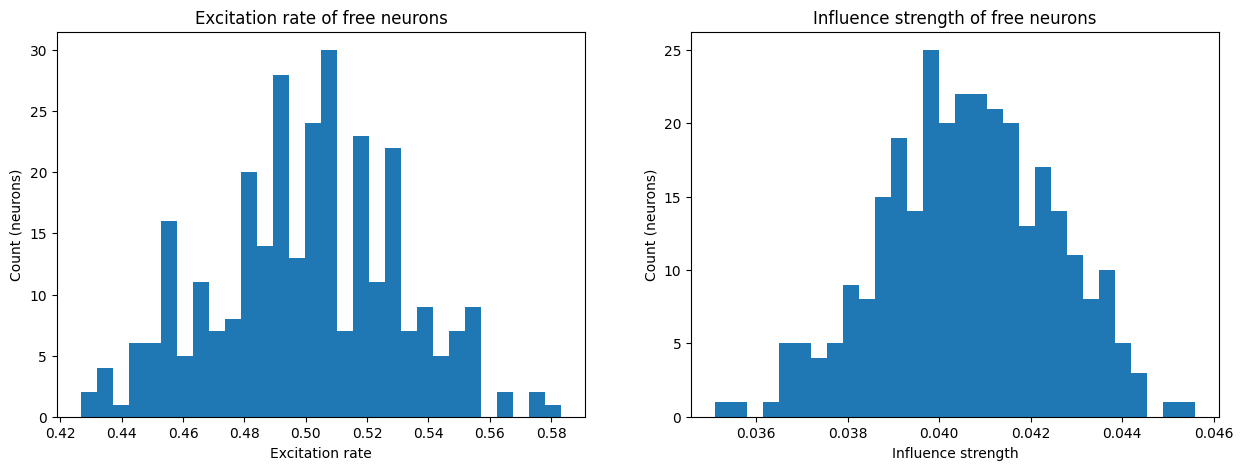

In [ ]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# fraction of positive outgoing (internal) couplings for each free neuron
excitation_rates = (model.couplings[0, N:, H + N : 2 * H] > 0).mean(
    dim=0, dtype=torch.float32
)
# average magnitude of outgoing (internal) couplings for each free neuron
influence_strengths = model.couplings[0, N:, H + N : 2 * H].abs().mean(dim=0)
ax = axs[0]
ax.hist(excitation_rates.cpu(), bins=30)
ax.set_xlabel("Excitation rate")
ax.set_ylabel("Count (neurons)")
ax.set_title("Excitation rate of free neurons")
ax = axs[1]
ax.hist(influence_strengths.cpu(), bins=30)
ax.set_xlabel("Influence strength")
ax.set_ylabel("Count (neurons)")
ax.set_title("Influence strength of free neurons")
plt.show()

## Chaos

In [ ]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

max_sweeps = 20
model.init_noise = 1.0


def plot_trajectory(states, unsats):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=False, squeeze=False)

    # unsat evolution
    unsat_evolution = unsats[:, 1:, :, :].mean(dim=(0, -1), dtype=torch.float32).cpu()
    ax = axs[0, 0]
    for l in range(num_layers):
        ax.plot(
            unsat_evolution[:, l], label=f"Layer {l}" if l < num_layers else "Readout"
        )
    ax.set_xlabel("Sweeps")
    ax.set_ylabel("Unsat fraction")
    ax.set_title("Unsat fraction evolution")
    ax.grid()
    ax.legend()
    ax.set_ylim(-0.005)

    # heatmap of similarities between different timesteps' states
    B, T, L, H = states.shape
    similarities = torch.zeros((L, T, T))
    for t1 in range(T):
        for t2 in range(T):
            sims = (states[:, t1, 1:-2, :] == states[:, t2, 1:-2, :]).mean(
                dim=(0, -1), dtype=torch.float32
            )  # (L,). exclude readout
            similarities[:, t1, t2] = sims.cpu()
    ax = axs[0, 1]
    l = 1
    sns.heatmap(
        similarities[l, :, :],
        ax=ax,
        cmap="seismic",
        vmin=0,
        vmax=1,
        label=f"Layer {l}" if l < num_layers else "Readout",
    )
    ax.set_xlabel("Time step")
    ax.set_ylabel("Time step")
    ax.set_title(
        "Average (over patterns) similarity between states at different time steps along trajectories - Layer 0"
    )
    plt.show()


def quantify_chaos(x, y):
    num_states = 50
    probas_flip = np.array(
        [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
    )
    num_trials = 100
    sims = defaultdict(list)

    for s in range(num_states):
        reference_state = model.initialize_state(x, y, "noisy_zeros")
        reference_final, _, _ = model.relax(
            reference_state.clone(), max_sweeps, ignore_right=4
        )

        for p in probas_flip:
            state = reference_state.clone().repeat(num_trials, 1, 1)
            mask = torch.rand(num_trials, num_layers, H, device=device) < p
            state[:, 1:-2, :][mask] *= -1
            # print(
            #     (reference_state[:, 1:-2, :] == state[:, 1:-2, :]).mean(dtype=torch.float32)
            # )

            perturbed_final, _, _ = model.relax(
                state.clone(), max_sweeps, ignore_right=4
            )
            sim = (perturbed_final[:, 1:-2, :] == reference_final[:, 1:-2, :]).mean(
                dtype=torch.float32
            )
            sims[p].append(sim.cpu().numpy())

    plt.figure(figsize=(15, 5))
    mean_sims = [np.mean(sims[p]) for p in probas_flip]
    plt.plot(probas_flip * H, mean_sims)
    plt.xlabel("Avg number of flipped neurons")
    plt.ylabel("Similarity with reference state after convergence")
    plt.grid()
    plt.show()

In [ ]:
B = 32
mode = "noisy_zeros"

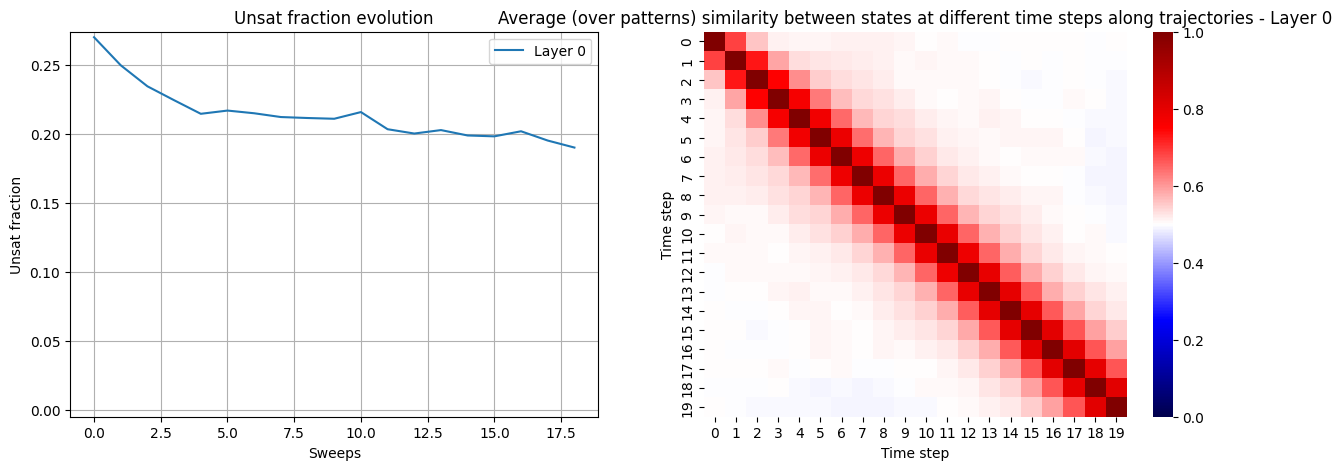

In [ ]:
x = torch.zeros((B, N))
y = torch.zeros((B, C))
state = model.initialize_state(x, y, mode)
states, unsats = handler.relaxation_trajectory(
    x, y, max_sweeps, ignore_right=4, state=state
)
plot_trajectory(states, unsats)

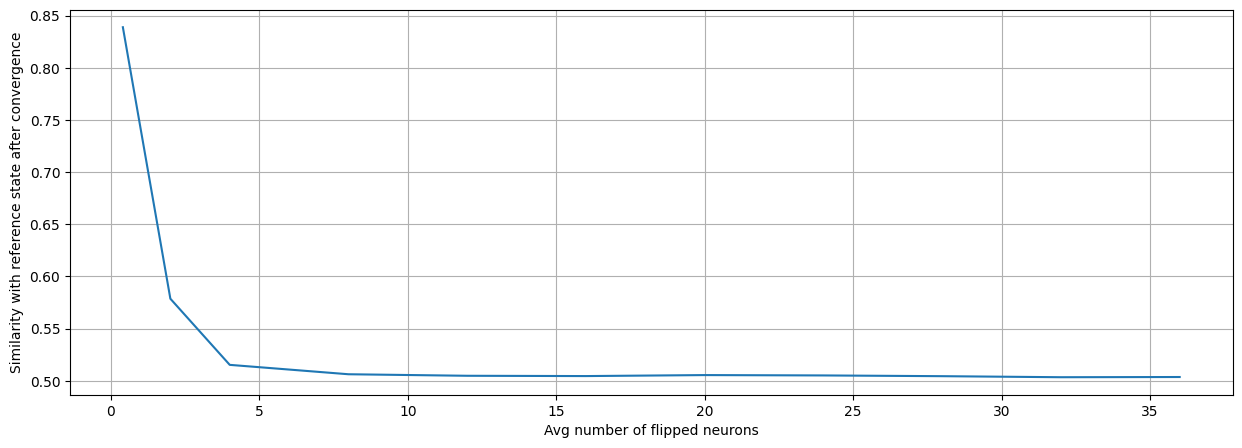

In [ ]:
x = torch.zeros((1, N))
y = torch.zeros((1, C))
quantify_chaos(x, y)

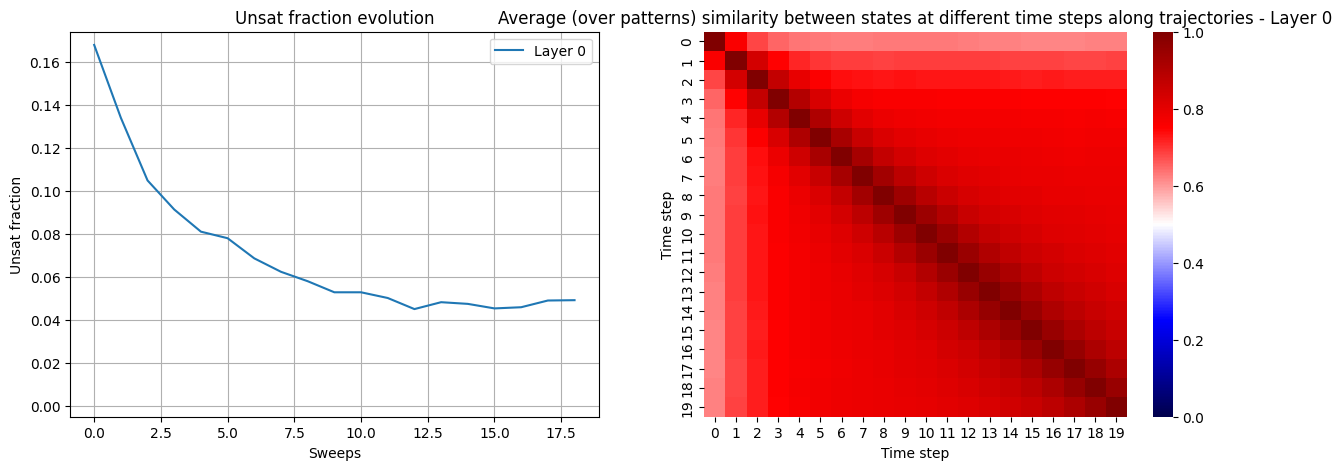

In [ ]:
x = torch.randint(0, 2, (B, N), device=device).float() * 2 - 1
y = torch.zeros((B, C), device=device)
state = model.initialize_state(x, y, mode)
states, unsats = handler.relaxation_trajectory(
    x, y, max_sweeps, ignore_right=4, state=state
)
plot_trajectory(states, unsats)

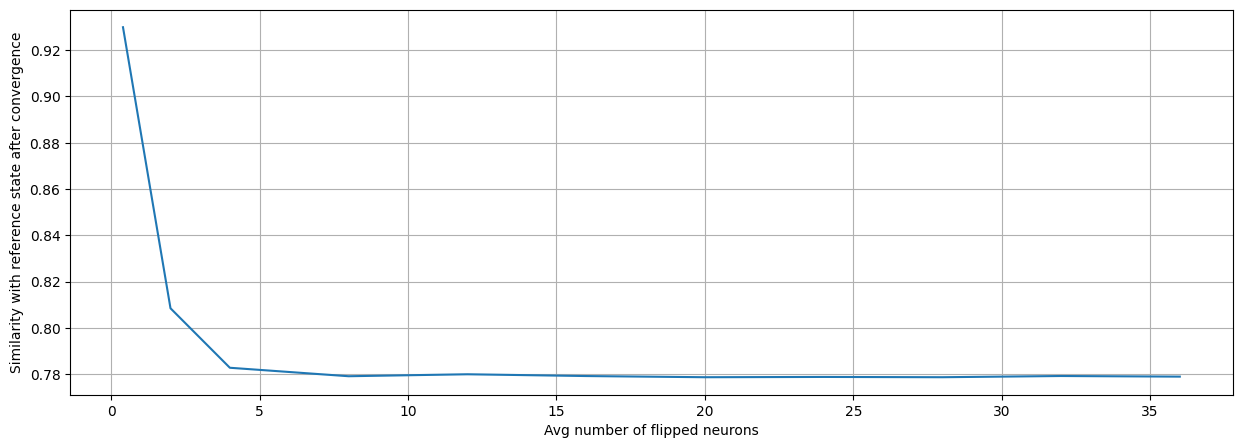

In [ ]:
x = torch.randint(0, 2, (1, N), device=device).float() * 2 - 1
y = torch.zeros((1, C), device=device)
quantify_chaos(x, y)

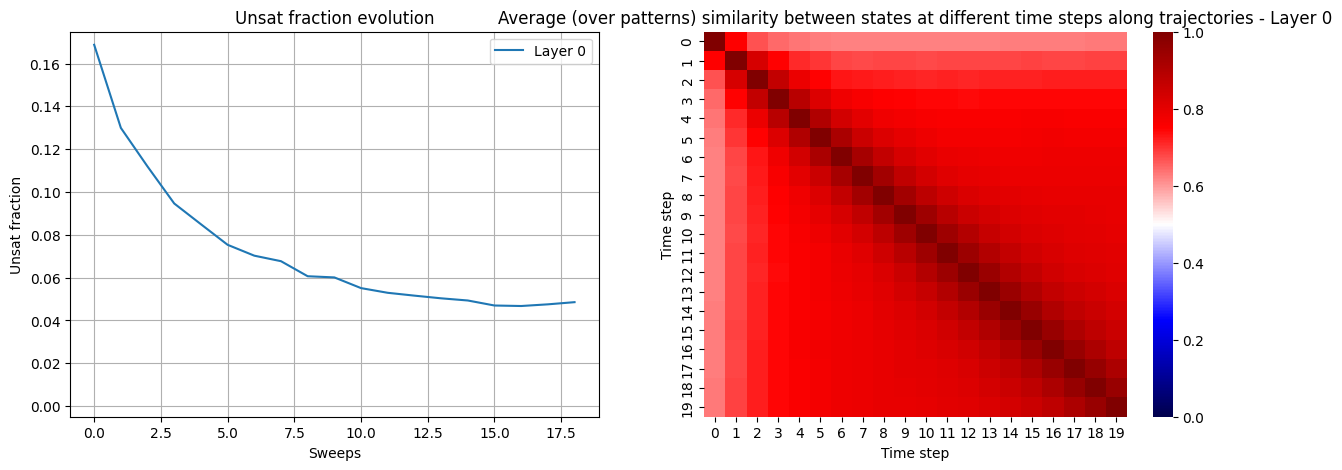

In [ ]:
idxs = torch.randint(0, len(train_inputs), (B,)).tolist()
x = train_inputs[idxs]
y = torch.zeros((B, C), device=device)
state = model.initialize_state(x, y, mode)
states, unsats = handler.relaxation_trajectory(
    x, y, max_sweeps, ignore_right=4, state=state
)
plot_trajectory(states, unsats)

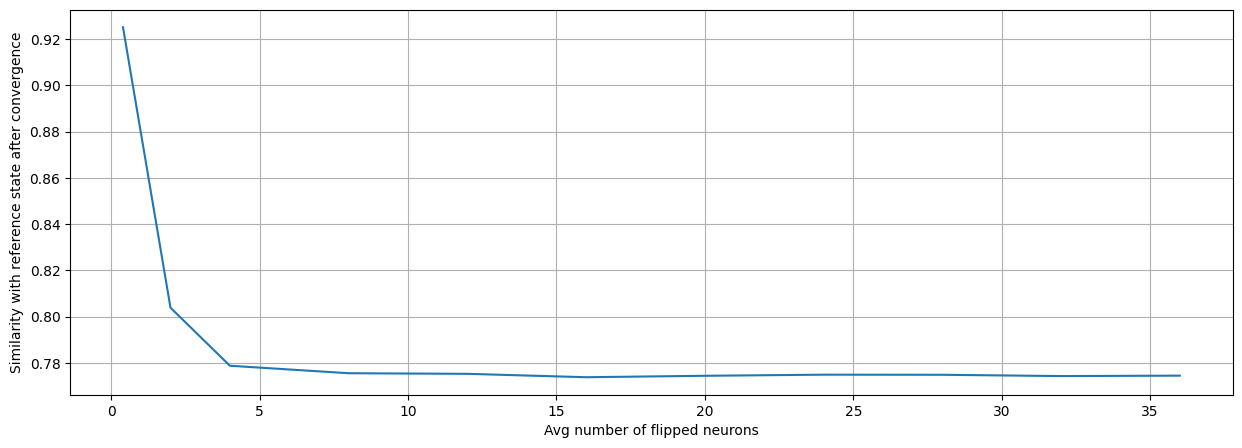

In [ ]:
idxs = torch.randint(0, len(train_inputs), (1,)).tolist()
x = train_inputs[idxs]
y = torch.zeros((1, C), device=device)
quantify_chaos(x, y)

In [ ]:
logs = handler.train_epoch(
    train_inputs,
    train_targets,
    max_steps,
    batch_size,
)
out = handler.evaluate(train_inputs, train_targets, max_steps)
is_correct = out["logits"].argmax(dim=1) == train_targets.argmax(dim=1)
print("Accuracy:", is_correct.mean(dtype=torch.float32).float().item())
for i in range(C):
    print(
        f"Class {i}: {is_correct[train_targets[:, i] == 1].mean(dtype=torch.float32):.2f}"
    )

Accuracy: 0.856333315372467
Class 0: 0.95
Class 1: 0.97
Class 2: 0.82
Class 3: 0.83
Class 4: 0.88
Class 5: 0.75
Class 6: 0.93
Class 7: 0.92
Class 8: 0.75
Class 9: 0.73


In [ ]:
B = 32
mode = "noisy_zeros"

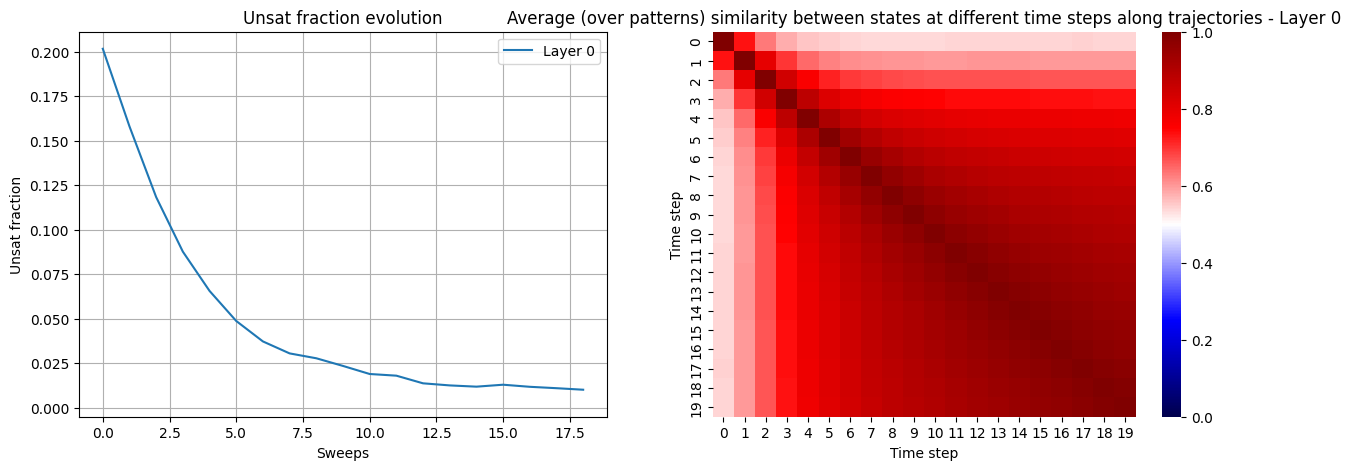

In [ ]:
x = torch.zeros((B, N))
y = torch.zeros((B, C))
state = model.initialize_state(x, y, mode)
states, unsats = handler.relaxation_trajectory(
    x, y, max_sweeps, ignore_right=4, state=state
)
plot_trajectory(states, unsats)

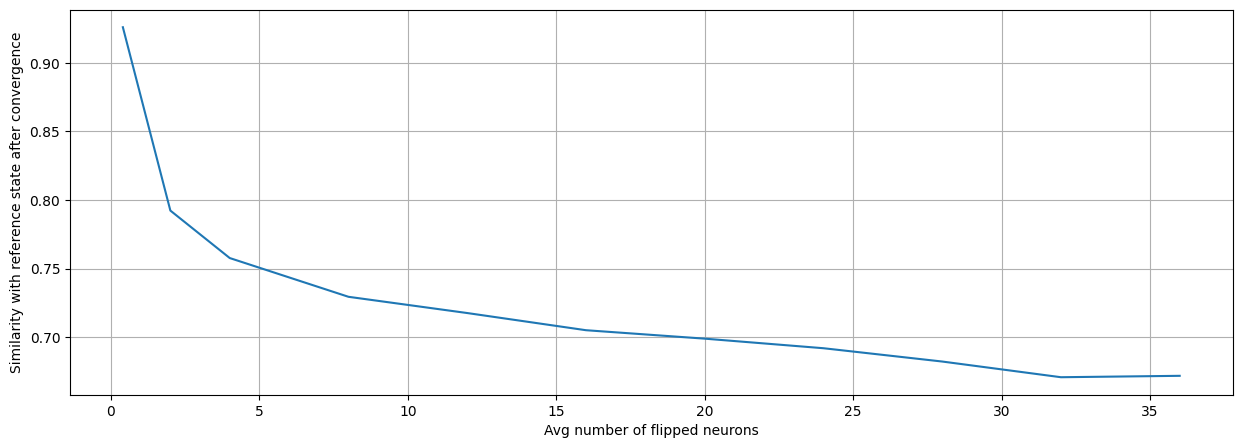

In [ ]:
x = torch.zeros((1, N))
y = torch.zeros((1, C))
quantify_chaos(x, y)

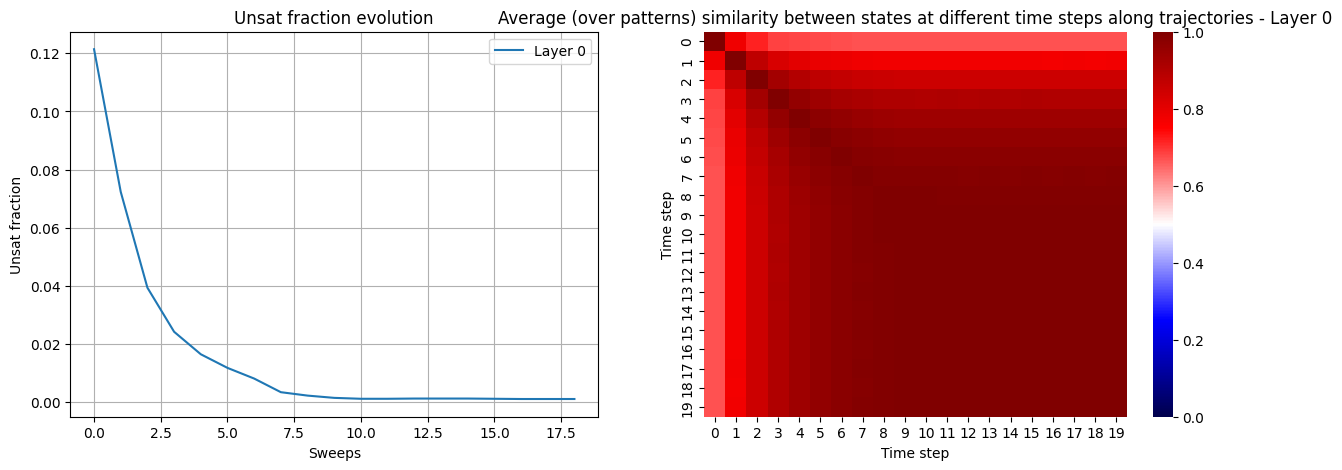

In [ ]:
x = torch.randint(0, 2, (B, N), device=device).float() * 2 - 1
y = torch.zeros((B, C), device=device)
state = model.initialize_state(x, y, mode)
states, unsats = handler.relaxation_trajectory(
    x, y, max_sweeps, ignore_right=4, state=state
)
plot_trajectory(states, unsats)

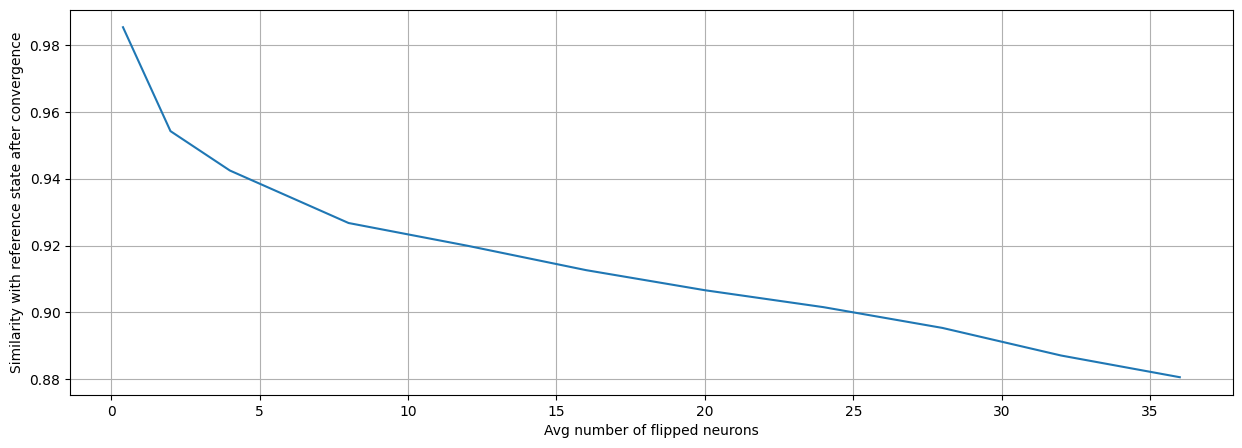

In [ ]:
x = torch.randint(0, 2, (1, N), device=device).float() * 2 - 1
y = torch.zeros((1, C), device=device)
quantify_chaos(x, y)

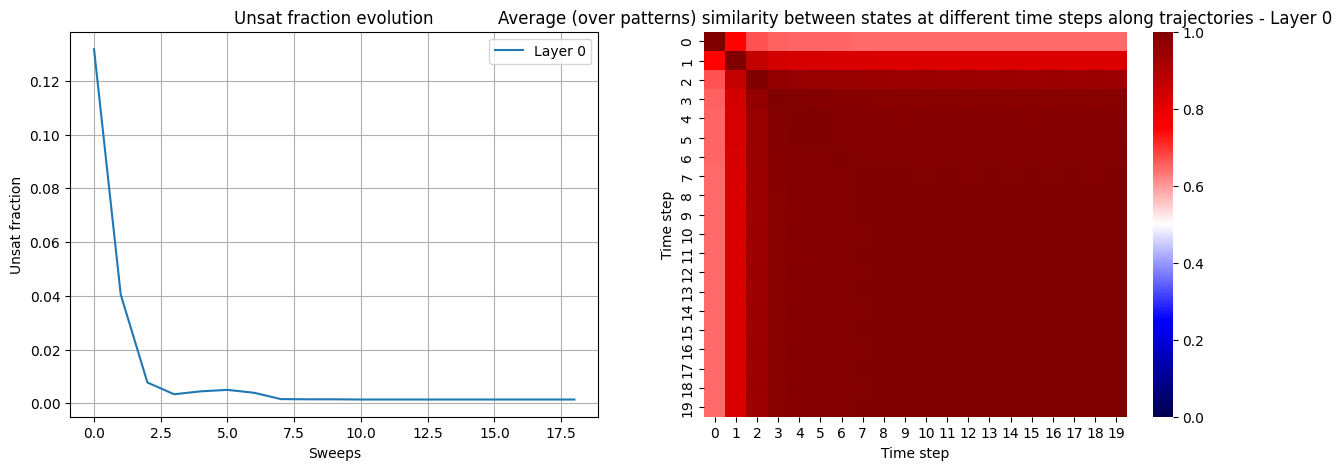

In [ ]:
idxs = torch.randint(0, len(train_inputs), (B,)).tolist()
x = train_inputs[idxs]
y = torch.zeros((B, C), device=device)
state = model.initialize_state(x, y, mode)
states, unsats = handler.relaxation_trajectory(
    x, y, max_sweeps, ignore_right=4, state=state
)
plot_trajectory(states, unsats)

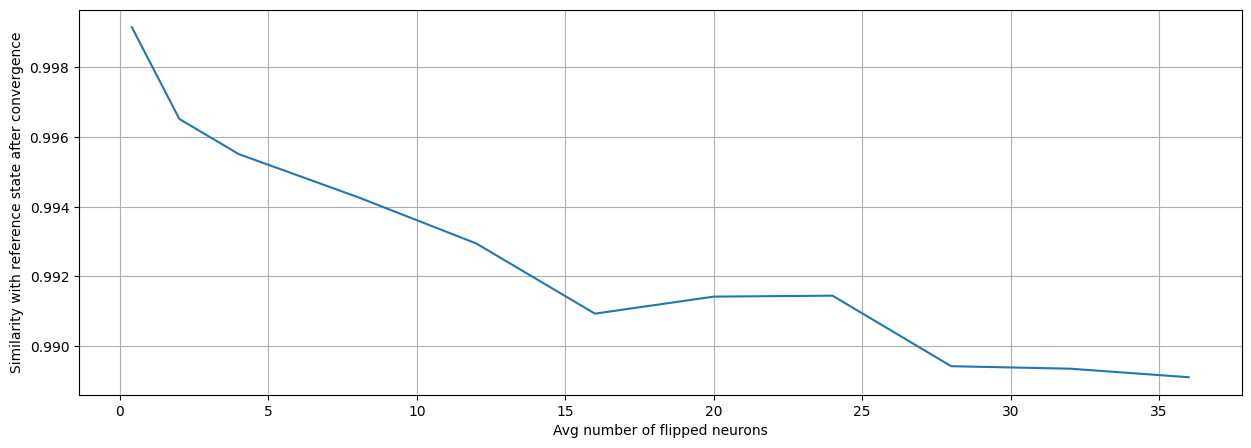

In [ ]:
idxs = torch.randint(0, len(train_inputs), (1,)).tolist()
x = train_inputs[idxs]
y = torch.zeros((1, C), device=device)
quantify_chaos(x, y)

## Multi-Step Training

In [ ]:
lr_cfg, weight_decay_cfg, threshold_cfg = (
    torch.tensor(lr),
    torch.tensor(weight_decay),
    torch.tensor(threshold),
)
lr_input_skip = model.lr_input_skip.clone()
lr_input_output_skip = model.lr_input_output_skip.clone()
weight_decay_input_skip = model.weight_decay_input_skip.clone()
weight_decay_input_output_skip = model.weight_decay_input_output_skip.clone()

/var/folders/jy/x5558th97mjgtzp6f33ryf840000gn/T/ipykernel_25564/1357943539.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(lr),
/var/folders/jy/x5558th97mjgtzp6f33ryf840000gn/T/ipykernel_25564/1357943539.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(weight_decay),
/var/folders/jy/x5558th97mjgtzp6f33ryf840000gn/T/ipykernel_25564/1357943539.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold),


In [ ]:
lr = lr_cfg.clone()
lr[:-2] = 0.0
weight_decay = weight_decay_cfg.clone()
threshold = threshold_cfg.clone()
model.prepare_tensors(
    lr,
    weight_decay,
    threshold,
    torch.zeros_like(lr_input_skip),
    lr_input_output_skip,
    weight_decay_input_skip,
    weight_decay_input_output_skip,
)  # re-create lr tensor
model.set_wback(torch.zeros_like(model.W_back))  # no wback feedback
model.symmetric_W = (
    False  # otherwise, wback might be updated and start providing feedback
)
handler.begin_curriculum = 1.0
handler.p_curriculum = 0.5

In [ ]:
num_epochs_warmup = 10
handler.train_loop(
    num_epochs_warmup,
    train_inputs,
    train_targets,
    max_steps,
    batch_size,
    eval_interval=eval_interval,
    eval_inputs=eval_inputs,
    eval_targets=eval_targets,
)

{'train_acc_history': [0.7908333539962769,
  0.7911666631698608,
  0.7950000166893005,
  0.7906666398048401,
  0.7864999771118164,
  0.7835000157356262,
  0.7916666865348816,
  0.7935000061988831,
  0.7898333072662354,
  0.7871666550636292],
 'eval_acc_history': [0.7306666374206543,
  0.7306666374206543,
  0.7333333492279053,
  0.7329999804496765,
  0.7360000014305115,
  0.7256666421890259,
  0.7323333621025085,
  0.7336666584014893,
  0.7289999723434448,
  0.7273333072662354],
 'train_representations': [],
 'eval_representations': [],
 'update_representations': [],
 'W_forth': array([[[-0.17113933,  0.25361472,  0.6140037 , ...,  0.03005777,
           0.7094634 , -0.17213702],
         [-0.10868561,  0.43231514,  0.24426597, ..., -0.13992152,
          -0.11109164,  0.0094131 ],
         [-0.00686581,  0.36210606,  0.92100394, ..., -0.04788563,
          -0.46495575, -0.1558466 ],
         ...,
         [-0.07306793,  0.16571888,  0.39745504, ...,  0.0367153 ,
           0.04518563, 

In [ ]:
logs = handler.train_epoch(
    train_inputs,
    train_targets,
    max_steps,
    batch_size,
)
out = handler.evaluate(train_inputs, train_targets, max_steps)
is_correct = out["logits"].argmax(dim=1) == train_targets.argmax(dim=1)
print("Accuracy:", is_correct.mean(dtype=torch.float32).float().item())
for i in range(C):
    print(
        f"Class {i}: {is_correct[train_targets[:, i] == 1].mean(dtype=torch.float32):.2f}"
    )

Accuracy: 0.7933333516120911
Class 0: 0.95
Class 1: 0.94
Class 2: 0.85
Class 3: 0.76
Class 4: 0.80
Class 5: 0.50
Class 6: 0.82
Class 7: 0.90
Class 8: 0.68
Class 9: 0.69


In [ ]:
model.set_wback(
    model.wforth2wback(model.W_forth)
)  # because we had set it to 0. as if we were initializing wback and wforth anew, make them symmetric
model.symmetric_W = symmetric_W
model.symmetrize_W()  # for plots with buggy option

lr = lr_cfg.clone()
lr[-2:] = 0.0
weight_decay = weight_decay_cfg.clone()
threshold = threshold_cfg.clone()
model.prepare_tensors(
    lr,
    weight_decay,
    threshold,
    lr_input_skip,
    lr_input_output_skip,
    weight_decay_input_skip,
    weight_decay_input_output_skip,
)  # re-create lr tensor
handler.begin_curriculum = 1.0
handler.p_curriculum = 0.5

In [ ]:
num_epochs_couplings = 10
handler.train_loop(
    num_epochs_couplings,
    train_inputs,
    train_targets,
    max_steps,
    batch_size,
    eval_interval=eval_interval,
    eval_inputs=eval_inputs,
    eval_targets=eval_targets,
)

{'train_acc_history': [0.7901666760444641,
  0.7789999842643738,
  0.7886666655540466,
  0.7875000238418579,
  0.7821666598320007,
  0.7818333506584167,
  0.7760000228881836,
  0.778333306312561,
  0.7785000205039978,
  0.7804999947547913],
 'eval_acc_history': [0.731333315372467,
  0.7396666407585144,
  0.7363333106040955,
  0.7310000061988831,
  0.7286666631698608,
  0.7289999723434448,
  0.7283333539962769,
  0.7303333282470703,
  0.7279999852180481,
  0.722000002861023],
 'train_representations': [],
 'eval_representations': [],
 'update_representations': [],
 'W_forth': array([[[-0.17113933,  0.25361472,  0.6140037 , ...,  0.03005777,
           0.7094634 , -0.17213702],
         [-0.10868561,  0.43231514,  0.24426597, ..., -0.13992152,
          -0.11109164,  0.0094131 ],
         [-0.00686581,  0.36210606,  0.92100394, ..., -0.04788563,
          -0.46495575, -0.1558466 ],
         ...,
         [-0.07306793,  0.16571888,  0.39745504, ...,  0.0367153 ,
           0.04518563, -0.

In [ ]:
logs = handler.train_epoch(
    train_inputs,
    train_targets,
    max_steps,
    batch_size,
)
out = handler.evaluate(train_inputs, train_targets, max_steps)
is_correct = out["logits"].argmax(dim=1) == train_targets.argmax(dim=1)
print("Accuracy:", is_correct.mean(dtype=torch.float32).float().item())
for i in range(C):
    print(
        f"Class {i}: {is_correct[train_targets[:, i] == 1].mean(dtype=torch.float32):.2f}"
    )

Accuracy: 0.7795000076293945
Class 0: 0.93
Class 1: 0.94
Class 2: 0.85
Class 3: 0.75
Class 4: 0.82
Class 5: 0.49
Class 6: 0.82
Class 7: 0.88
Class 8: 0.62
Class 9: 0.65
